# import packages

In [226]:
#libraries and dirrectory 
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import patientFunctions as ptfn
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression


# directory management

In [227]:
#location of original data
starting_directory = os.getcwd()


# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '012 Processed Data/data-2024-06-05' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

new_dirrectory = path

os.chdir(new_dirrectory)

In [228]:
#updates to directory management
# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '015_Mistic2025' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

# parent_dir = path
outputDir = path

## naming file outputs

In [229]:
folderNameHeader = "DFsForSVM_noNotes_t-60_"
folderNameCommon = ""
folderNameSuffix = "_20250513_v3"

fileNameHeader_1 = "DF_SVM_noNotes_t-60_"
# fileNameHeader_2 = "ALUnknownPts"
# fileNameCommon = "_Features"
fileNameSuffix = "_20250513_v3"

folder_data_out = ptfn.makeFolderPathForData(parent_dir=outputDir, folderName_header=folderNameHeader, 
                                        folderName_common=folderNameCommon, folderName_suffix=folderNameSuffix)


folderNameOut = folder_data_out

# Penalty scores used throughout for missing data and low time resolution

## length 1

In [230]:
#filler information for fits of 1 point
# one_point_STD = 0
one_point_r2 = -1
# one_point_residual_error = 0

## length 0

In [231]:
penalty_coef= np.nan
penalty_intercept = np.nan
penalty_R2 = np.nan
penalty_residual_error = np.nan
penalty_fillna = np.nan

In [232]:
penalty_echo = -1


## note data for T-01

In [233]:
# create fake note data for T-01 as a place holder, assuming they are doing well and have one measure
#assuming well
# replaceNotes = {'time from diagnosis to note (months)': [0] , 'ECOG Performance Status': [0], 'Karnofsky Performance Status': [100]}
#assuming symptomatic but not severe
# replaceNotes = {'time from diagnosis to note (months)': [0] , 'ECOG Performance Status': [2], 'Karnofsky Performance Status': [np.nan]}
#assuming not well 
replaceNotes = {'time from diagnosis to note (months)': [0] , 'ECOG Performance Status': [3], 'Karnofsky Performance Status': [np.nan]}

replaceNotes_df = pd.DataFrame.from_dict(replaceNotes)

In [234]:
replaceNotes_df

time from diagnosis to note (months)  ECOG Performance Status  \
0                                     0                        3   

   Karnofsky Performance Status  
0                           NaN

In [235]:
# ptDict['T-01'].MDnotes = replaceNotes

# collecting patient information

In [236]:
#importing patient data as dictionaries of dataframes

#build a dictionary of patients and their values 
ptFiles = ptfn.GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

ptDict = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = ptfn.patient(new_dirrectory, file, 4)
    ptDict[pt.ptID] = pt

In [237]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRITimeColumn = 'time from dagnosis to MRI (months)'
echoDates = {}
for pt in ptDict.keys():
    ptEchoData = ptDict[pt].echoData
    patientEchoDate = ptEchoData[EchoTimeColumn]
    if 'none' not in list(patientEchoDate):
        echoDates[pt] = patientEchoDate

#test to see if this still runs and if the data is correct

# patients of interest

In [238]:
#list of patients by amyloid status 

listPositive = []
listNegative = []
listOther = []

#T-01 was added to the list of patients to remove for having no note data
list_pts_remove = ["K-01", "G-01", "J-01", "L-02"]
#remove list_pts_remove from ptDict
for pt in list_pts_remove:
    if pt in ptDict:
        del ptDict[pt]

#get list of positive patients 
for pt in ptDict:
    ptALStatus = ptDict[pt].amyloid_status
    if ptALStatus == 'yes':
        listPositive.append(pt)
    elif ptALStatus == 'no':
        listNegative.append(pt)
    else:
        listOther.append(pt)


In [239]:

listKnown = listPositive + listNegative

In [240]:
len(listPositive)

21

## removing unknown patients from patient list

In [241]:
#changing dictionary of patients to only those with known status
#this fixes issues throughout the code where ptDict.keys() was used instead of listKnown
for pt in listOther:
    ptDict.pop(pt)

## replace note data for T-01

In [242]:
ptDict['T-01'].MDnotes = replaceNotes_df

# data is time greater than 2 months before diagnosis 

In [243]:
labsTimeColumn = 'RelTime(Days)'
# noteTimeColumn = 'time from diagnosis to note (months)'

for pt in ptDict.keys(): 
    #pull each data input type (labs and notes) and filter for only positive time
    ptLabs = ptDict[pt].labsData
    ptDict[pt].labsData = ptLabs.loc[ptLabs[labsTimeColumn] >= -60].reset_index()

    # #repeat for the note column 
    # ptNotes = ptDict[pt].MDnotes
    # ptDict[pt].MDnotes = ptNotes.loc[ptNotes[noteTimeColumn]>= 0].reset_index()


# labs of interest

labs of interest have at least one data point for each patient and aren't tagged as methods or limits of normality

In [244]:
# First cleaning the lab names while keeping 'RelTime(Days)' unchanged
cleanLabNames = [re.sub(r'\(.*?\)', '', x).replace("Result", '').replace('.', '').strip() if x != 'RelTime(Days)' else x for x in ptDict['E-01'].labsData.columns]

In [245]:
#apply the clean lab names to all patients labsData
for pt in ptDict:
    ptDict[pt].labsData.columns = cleanLabNames

In [246]:
# cleaning troponin where it is a string entry of '<0.010' or BNP has '<5' as an entry to 0
for pt in ptDict.keys():
    ptDict[pt].labsData['Troponin-T'].replace('<0.010', 0, inplace=True)
    ptDict[pt].labsData['NT Pro BNP'].replace('<5', 0, inplace=True)


C:\Users\maega\AppData\Local\Temp\ipykernel_32852\3625564062.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ptDict[pt].labsData['Troponin-T'].replace('<0.010', 0, inplace=True)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\3625564062.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ptDic

In [247]:
#for patient labs, convert to boolean and find the number of each lab (true)
ptLabsBool = {}
for pt in ptDict.keys():
    ptLabsData = ptDict[pt].labsData
    #convert to boolean if not nan
    ptLabsData = ptLabsData.notna() #not sure this is capturing the null data correctly
    #find the number of each lab (true)
    ptLabsData = ptLabsData.sum(axis=0) #check the axis
    #add to the dictionary describing the number of each lab the patient has
    ptLabsBool[pt] = ptLabsData

#then find frequency of labs across all patients
ptLabsBool_df = pd.DataFrame(ptLabsBool)
#count frequency of value in a column 

dict_value_counts_labs ={}
for lab in ptLabsBool_df.index:
    #call a row and perform value counts, save it to a key as the lab name in the dictionary
    dict_value_counts_labs[lab] = ptLabsBool_df.loc[lab].value_counts()

#convert to dataframe and transpose
df_value_counts_labs = pd.DataFrame(dict_value_counts_labs).T

In [248]:
#removing things that aren't lab values
omit = ['Method',"Lower Limit of Normal", "Upper Limit of Normal"]

In [249]:
featurecounts_df = ptLabsBool_df[~ptLabsBool_df.index.str.contains('|'.join(omit))].T

In [250]:
ptfn.outputToExcel(fileName_header = "FeatureCounts", fileName_Common = "",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'counts per pt', df_data = featurecounts_df)

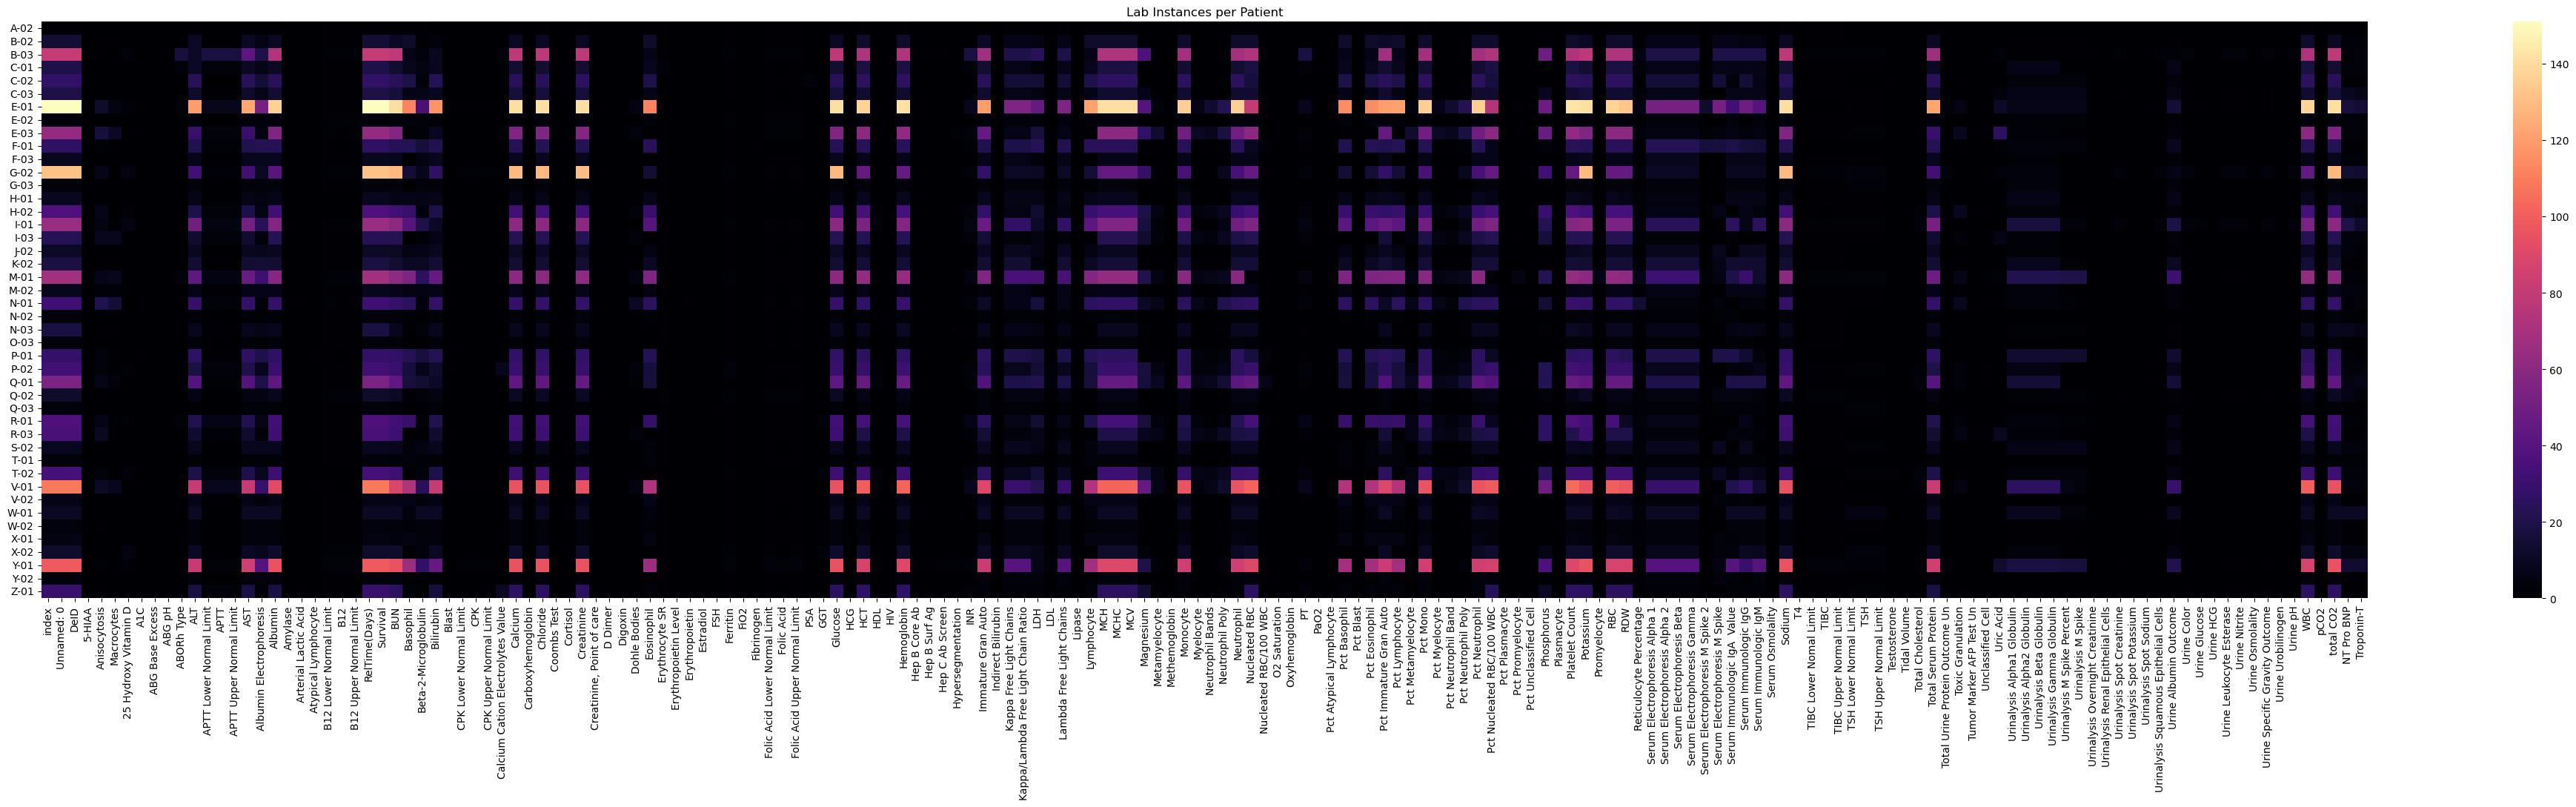

In [251]:
#heatmap of counts
fig, ax = plt.subplots(figsize=(40,11))
sns.heatmap(featurecounts_df, ax= ax, annot_kws={"size": 6}, cmap='magma')
ax.set_title("Lab Instances per Patient")
plt.tight_layout()
figname = ptfn.outputFiguresPath(fileName_header= "LabsCountsHeatmap_", fileName_mid= "allpts_", fileName_suff=fileNameSuffix, parent_dir=outputDir, folderName=folderNameOut)
fig.savefig(figname)

In [252]:
#removing things that aren't lab values
omit = ['Method',"Lower Limit of Normal", "Upper Limit of Normal"]

#drop the rows whos string contains items from the omit list
df_value_counts_labs_filtered = df_value_counts_labs[~df_value_counts_labs.index.str.contains('|'.join(omit))]

#collect the rows where the column"0" is null
df_value_counts_labs_filtered = df_value_counts_labs_filtered[df_value_counts_labs_filtered[0].isnull()]

#print the index of df_value_counts_labs_filtered
filteredLabs = df_value_counts_labs_filtered.index.tolist()

In [253]:
#remove 'DeID', 'Survival(Mo)', 'RelTime(Days)', 'Unnamed: 0' from the filteredLabs list
filteredLabs = [x for x in filteredLabs if x not in ['DeID', 'Survival', 'RelTime(Days)', 'Unnamed: 0', 'index']]

In [254]:
filteredLabs

['ALT',
 'AST',
 'Albumin Electrophoresis',
 'Albumin',
 'BUN',
 'Beta-2-Microglobulin',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Glucose',
 'HCT',
 'Hemoglobin',
 'Immature Gran Auto',
 'Kappa Free Light Chains',
 'Kappa/Lambda Free Light Chain Ratio',
 'LDH',
 'Lambda Free Light Chains',
 'MCH',
 'MCHC',
 'MCV',
 'Monocyte',
 'Neutrophil',
 'Nucleated RBC',
 'Pct Immature Gran Auto',
 'Pct Mono',
 'Pct Neutrophil',
 'Platelet Count',
 'Potassium',
 'RBC',
 'Serum Electrophoresis Alpha 1',
 'Serum Electrophoresis Alpha 2',
 'Serum Electrophoresis Beta',
 'Serum Electrophoresis Gamma',
 'Sodium',
 'Total Serum Protein',
 'WBC',
 'total CO2',
 'NT Pro BNP',
 'Troponin-T']

In [255]:
len(filteredLabs)

39

In [256]:
filteredLabs_df = pd.DataFrame(filteredLabs)

In [257]:
#saving the list of labs to a file
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

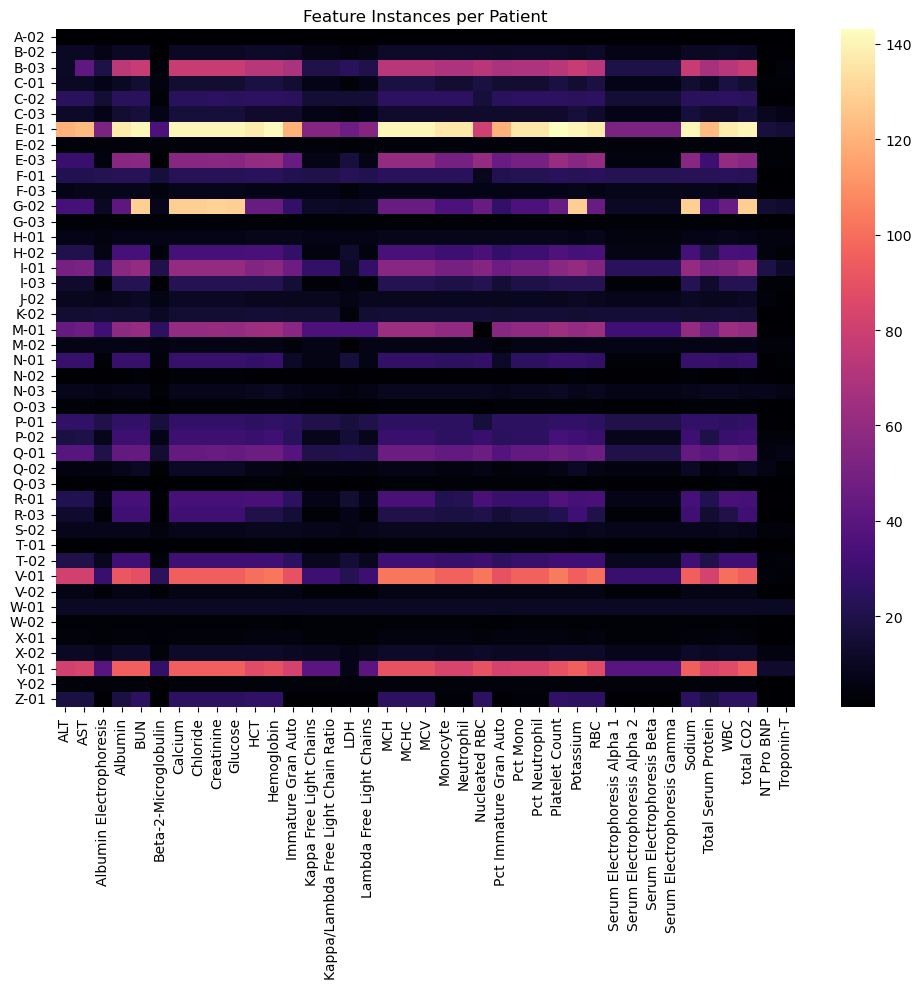

In [258]:
#heatmap of counts of selected features
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(featurecounts_df[filteredLabs], ax= ax, annot_kws={"size": 6}, cmap = 'magma')
ax.set_title("Feature Instances per Patient")
plt.tight_layout()

figname = ptfn.outputFiguresPath(fileName_header= "FeaturesCountsHeatmap_", fileName_mid= "allpts_", fileName_suff=fileNameSuffix, parent_dir=outputDir, folderName=folderNameOut)
fig.savefig(figname)

## slice of patient data near echo or MRI date

In [259]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRITimeColumn = 'time from dagnosis to MRI (months)'
#convert the echoDates from months to days
imagingDates_days = {}
for pt in ptDict.keys():
    ptEchoData = ptDict[pt].echoData
    patientEchoDate = ptEchoData[EchoTimeColumn]
    #if the patientEchoDate is not 'none' then convert to days
    if 'none' not in list(patientEchoDate):
        ptImageDate = patientEchoDate * 30.44
        imagingDates_days[pt] = ptImageDate

    #if the patientEchoDate is 'none' then find time "time from dagnosis to MRI (months)" and convert to days
    if 'none' in list(patientEchoDate):
        patientMRIDate = ptEchoData[MRITimeColumn]
        if 'none' not in list(patientMRIDate):
            ptImageDate = patientMRIDate * 30.44
            imagingDates_days[pt] = ptImageDate

In [260]:
ptData_ImagingAdj = {}
ptDateOfLabs_imageAdj = {} #dictionary of the date of labs near imaging date
for pt in ptDict.keys(): #uses only the list of known patients
    ptLabsData = ptDict[pt].labsData
    #call the row of data where the RelTime(Days) is closest to the value of imagingDates_days[pt]
    ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
    ptDateOfLabs_imageAdj[pt] = ptLabsData_slice.at[0, 'RelTime(Days)']
    ptData_ImagingAdj[pt] = ptLabsData_slice[filteredLabs].iloc[0]  #single row

#convert to dataframe
ptData_ImagingAdj_df = pd.DataFrame.from_dict(ptData_ImagingAdj, orient='index')


C:\Users\maega\AppData\Local\Temp\ipykernel_32852\3407564317.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\3407564317.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\3407564317.py:6: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[

In [261]:
ptData_ImagingAdj_df.loc[listKnown]

ALT    AST  Albumin Electrophoresis  Albumin   BUN  \
B-02   19.0   14.0                      3.9      4.1  39.0   
C-03   69.0  102.0                      3.0      2.8  35.0   
E-01    NaN   21.0                      4.4      4.5  43.0   
E-02   28.0   22.0                      2.9      2.4  34.0   
F-03    7.0   12.0                      4.3      4.1  29.0   
G-02   13.0   14.0                      2.7      3.2  11.0   
I-01   19.0   29.0                      2.2      1.9  10.0   
I-03   24.0   30.0                     51.4      1.8  16.0   
J-02   60.0   38.0                      4.0      4.0   9.0   
K-02   10.0   22.0                      2.9      3.0  47.0   
M-02   90.0   59.0                      4.6      4.5  49.0   
N-03    NaN    NaN                      3.4      NaN   NaN   
O-03   30.0   43.0                      3.7      3.9  17.0   
Q-02   22.0   30.0                      3.8      3.6  30.0   
Q-03    NaN   13.0                      3.3      3.4  23.0   
T-01   18.0   21.0                      4.3      4.3  22.0   
V-02   16.0   23.0                      2.3      2.2  20.0   
W-01    8.0    8.0                      2.9      3.3  11.0   
X-01   13.0   19.0                      3.0      3.1  25.0   
X-02   29.0   31.0                      4.0      4.2  53.0   
Y-02   15.0   29.0                      2.0      1.3  30.0   
A-02    7.0   19.0                      3.9      4.3  27.0   
B-03    6.0    9.0                      3.1      3.3  39.0   
C-01   20.0   17.0                      4.4      4.5  16.0   
C-02   21.0   19.0                      4.7      4.0  20.0   
E-03   26.0   34.0                      1.0      1.8  13.0   
F-01    NaN    NaN                      3.4      4.0  14.0   
G-03   11.0   21.0                      4.8      4.8  13.0   
H-01   26.0   24.0                      NaN      4.5  13.0   
H-02    NaN    NaN                      NaN      NaN   NaN   
M-01   28.0   28.0                      4.6      4.6  17.0   
N-01   11.0   28.0                      4.3      4.1  19.0   
N-02   22.0   22.0                      3.8      4.0  23.0   
P-01   85.0   48.0                      2.9      3.2  35.0   
P-02   20.0   21.0                      3.7      3.8   8.0   
Q-01   14.0   16.0                      4.3      4.2   8.0   
R-01   16.0   21.0                      4.3      4.4  12.0   
R-03   31.0   23.0                      2.6      2.8  40.0   
S-02   26.0   41.0                      2.6      2.8  11.0   
T-02    NaN    NaN                      NaN      NaN   NaN   
V-01   18.0   15.0                      4.6      4.5  19.0   
W-02  126.0   38.0                      3.8      3.8  18.0   
Y-01   14.0   17.0                      2.9      2.5  31.0   
Z-01   23.0   31.0                      3.8      3.9  20.0   

      Beta-2-Microglobulin  Calcium  Chloride  Creatinine  Glucose  ...  \
B-02                  18.1      9.0     101.0         8.3    101.0  ...   
C-03                  12.0      8.9     105.0         2.5     84.0  ...   
E-01                   7.1      9.4     103.0         4.6    101.0  ...   
E-02                   7.5      8.4      99.0         3.9    167.0  ...   
F-03                   3.8      9.5     101.0         1.3     91.0  ...   
G-02                   4.0      9.5     104.0         1.1     95.0  ...   
I-01                   2.5      8.5     101.0         0.8    104.0  ...   
I-03                   2.6      8.2     107.0         1.2     84.0  ...   
J-02                   2.5      9.3      96.0         0.8     95.0  ...   
K-02                   8.0      9.3     104.0         3.5     94.0  ...   
M-02                   3.7      9.4      95.0         2.1     86.0  ...   
N-03                   NaN      NaN       NaN         NaN      NaN  ...   
O-03                   5.8      9.4      98.0         1.2     98.0  ...   
Q-02                   3.4     10.0      95.0         1.3     72.0  ...   
Q-03                   8.6      9.3      96.0         1.4     87.0  ...   
T-01             

Text(0.5, 1.0, 'Completeness of Imaging Adjacent Labs before replacement \n 1 =complete, 0=missing')

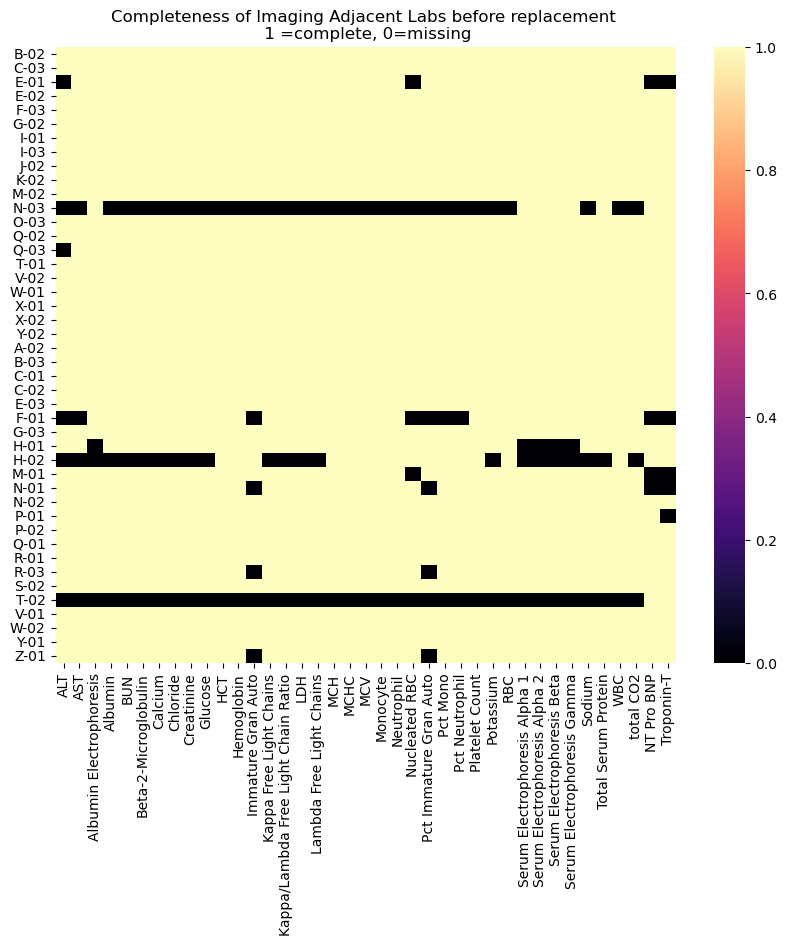

In [262]:
# Event plot of the completeness of the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot patients in listPositive with plasma colormap
sns.heatmap(ptData_ImagingAdj_df.loc[listKnown].notna(), cbar=True, cmap= 'magma',
            yticklabels=ptData_ImagingAdj_df.loc[listKnown].index, ax=ax)
plt.title("Completeness of Imaging Adjacent Labs before replacement \n 1 =complete, 0=missing")

In [263]:

#replace missing values in ptData_ImagingAdj_df with echo penality score
ptData_ImagingAdj_df = ptData_ImagingAdj_df.fillna(penalty_echo)


In [264]:
ptData_ImagingAdj_df.loc[listKnown]

ALT    AST  Albumin Electrophoresis  Albumin   BUN  \
B-02   19.0   14.0                      3.9      4.1  39.0   
C-03   69.0  102.0                      3.0      2.8  35.0   
E-01   -1.0   21.0                      4.4      4.5  43.0   
E-02   28.0   22.0                      2.9      2.4  34.0   
F-03    7.0   12.0                      4.3      4.1  29.0   
G-02   13.0   14.0                      2.7      3.2  11.0   
I-01   19.0   29.0                      2.2      1.9  10.0   
I-03   24.0   30.0                     51.4      1.8  16.0   
J-02   60.0   38.0                      4.0      4.0   9.0   
K-02   10.0   22.0                      2.9      3.0  47.0   
M-02   90.0   59.0                      4.6      4.5  49.0   
N-03   -1.0   -1.0                      3.4     -1.0  -1.0   
O-03   30.0   43.0                      3.7      3.9  17.0   
Q-02   22.0   30.0                      3.8      3.6  30.0   
Q-03   -1.0   13.0                      3.3      3.4  23.0   
T-01   18.0   21.0                      4.3      4.3  22.0   
V-02   16.0   23.0                      2.3      2.2  20.0   
W-01    8.0    8.0                      2.9      3.3  11.0   
X-01   13.0   19.0                      3.0      3.1  25.0   
X-02   29.0   31.0                      4.0      4.2  53.0   
Y-02   15.0   29.0                      2.0      1.3  30.0   
A-02    7.0   19.0                      3.9      4.3  27.0   
B-03    6.0    9.0                      3.1      3.3  39.0   
C-01   20.0   17.0                      4.4      4.5  16.0   
C-02   21.0   19.0                      4.7      4.0  20.0   
E-03   26.0   34.0                      1.0      1.8  13.0   
F-01   -1.0   -1.0                      3.4      4.0  14.0   
G-03   11.0   21.0                      4.8      4.8  13.0   
H-01   26.0   24.0                     -1.0      4.5  13.0   
H-02   -1.0   -1.0                     -1.0     -1.0  -1.0   
M-01   28.0   28.0                      4.6      4.6  17.0   
N-01   11.0   28.0                      4.3      4.1  19.0   
N-02   22.0   22.0                      3.8      4.0  23.0   
P-01   85.0   48.0                      2.9      3.2  35.0   
P-02   20.0   21.0                      3.7      3.8   8.0   
Q-01   14.0   16.0                      4.3      4.2   8.0   
R-01   16.0   21.0                      4.3      4.4  12.0   
R-03   31.0   23.0                      2.6      2.8  40.0   
S-02   26.0   41.0                      2.6      2.8  11.0   
T-02   -1.0   -1.0                     -1.0     -1.0  -1.0   
V-01   18.0   15.0                      4.6      4.5  19.0   
W-02  126.0   38.0                      3.8      3.8  18.0   
Y-01   14.0   17.0                      2.9      2.5  31.0   
Z-01   23.0   31.0                      3.8      3.9  20.0   

      Beta-2-Microglobulin  Calcium  Chloride  Creatinine  Glucose  ...  \
B-02                  18.1      9.0     101.0         8.3    101.0  ...   
C-03                  12.0      8.9     105.0         2.5     84.0  ...   
E-01                   7.1      9.4     103.0         4.6    101.0  ...   
E-02                   7.5      8.4      99.0         3.9    167.0  ...   
F-03                   3.8      9.5     101.0         1.3     91.0  ...   
G-02                   4.0      9.5     104.0         1.1     95.0  ...   
I-01                   2.5      8.5     101.0         0.8    104.0  ...   
I-03                   2.6      8.2     107.0         1.2     84.0  ...   
J-02                   2.5      9.3      96.0         0.8     95.0  ...   
K-02                   8.0      9.3     104.0         3.5     94.0  ...   
M-02                   3.7      9.4      95.0         2.1     86.0  ...   
N-03                  -1.0     -1.0      -1.0        -1.0     -1.0  ...   
O-03                   5.8      9.4      98.0         1.2     98.0  ...   
Q-02                   3.4     10.0      95.0         1.3     72.0  ...   
Q-03                   8.6      9.3      96.0         1.4     87.0  ...   
T-01             

Text(0.5, 1.0, 'Completeness of Imaging Adjacent Labs after replacement \n 1 =complete, 0=missing')

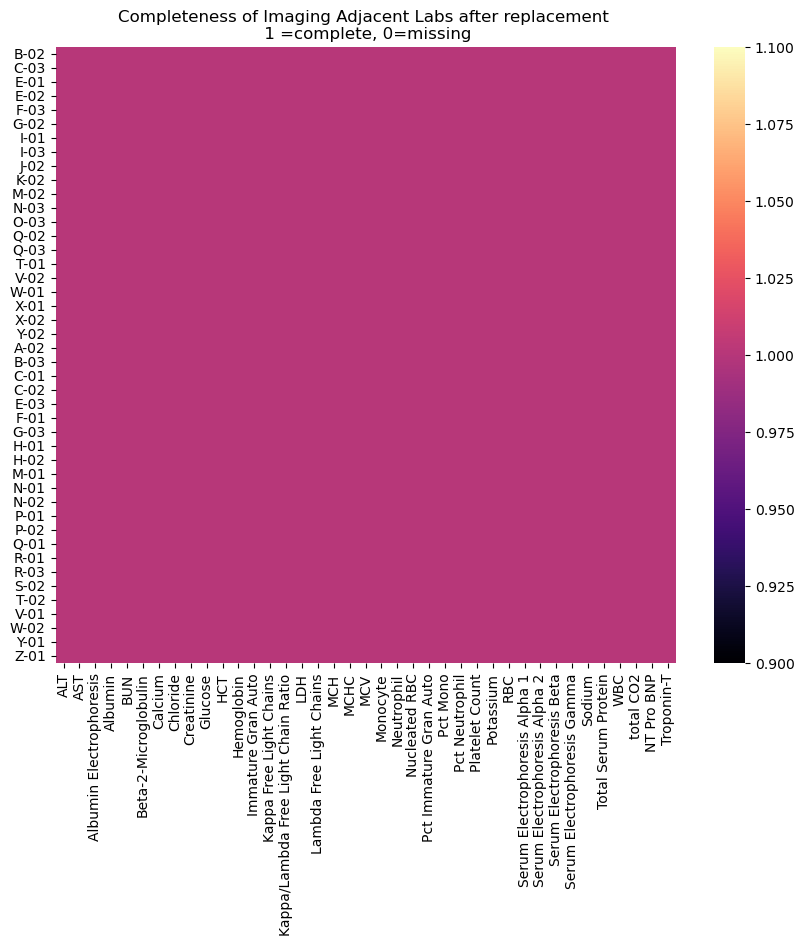

In [265]:
# Event plot of the completeness of the data
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(ptData_ImagingAdj_df.loc[listKnown].notna(), cbar=True, cmap= 'magma',
            yticklabels=ptData_ImagingAdj_df.loc[listKnown].index, ax=ax)
plt.title("Completeness of Imaging Adjacent Labs after replacement \n 1 =complete, 0=missing")


### timing of labs and imaging
collecting the timing of the labs and imaging in days for comparison

In [266]:
#convert imagingDates_days to dataframe
imagingDates_days_df = pd.DataFrame.from_dict(imagingDates_days, orient='index')
imagingDates_days_df.columns = ['ImagingDate']
#convert ptdateoflabs_imageAdj to dataframe 
ptDateOfLabs_imageAdj_df = pd.DataFrame.from_dict(ptDateOfLabs_imageAdj, orient='index', columns=['LabsDate'])
#concatenate the two dataframes
imagingAndLabDates_df = pd.concat([imagingDates_days_df, ptDateOfLabs_imageAdj_df], axis=1)
#reset the index to be the patient ID   
imagingAndLabDates_df.index.name = 'DeID'
imagingAndLabDates_df['timeDelta'] = imagingAndLabDates_df['LabsDate'] - imagingAndLabDates_df['ImagingDate'] if imagingAndLabDates_df['LabsDate'] is not None else np.nan

In [267]:
imagingAndLabDates_df.loc[listKnown]

ImagingDate  LabsDate    timeDelta
DeID                                    
B-02   134.950667         9  -125.950667
C-03    -1.014667        -2    -0.985333
E-01   659.533333        12  -647.533333
E-02    63.924000       108    44.076000
F-03   614.888000      1312   697.112000
G-02   133.936000        11  -122.936000
I-01    34.498667       -11   -45.498667
I-03    49.718667        20   -29.718667
J-02    27.396000        27    -0.396000
K-02    17.249333        -8   -25.249333
M-02   303.385333       210   -93.385333
N-03   135.965333        82   -53.965333
O-03    -2.029333        99   101.029333
Q-02  1058.297333       517  -541.297333
Q-03    21.308000        -8   -29.308000
T-01    89.290667        52   -37.290667
V-02  1515.912000      1483   -32.912000
W-01    50.733333        39   -11.733333
X-01  -119.730667       -34    85.730667
X-02   701.134667       529  -172.134667
Y-02    17.249333        61    43.750667
A-02   192.786667       190    -2.786667
B-03    71.026667        61   -10.026667
C-01    50.733333        49    -1.733333
C-02    98.422667        20   -78.422667
E-03   134.950667        94   -40.950667
F-01  4330.597333       963 -3367.597333
G-03    27.396000        19    -8.396000
H-01   136.980000       110   -26.980000
H-02   224.241333        28  -196.241333
M-01   391.661333        55  -336.661333
N-01    -8.117333       -10    -1.882667
N-02    57.836000        57    -0.836000
P-01  1212.526667        18 -1194.526667
P-02   277.004000       153  -124.004000
Q-01   350.060000        24  -326.060000
R-01   143.068000        59   -84.068000
R-03   161.332000       125   -36.332000
S-02   191.772000        -7  -198.772000
T-02   209.021333        87  -122.021333
V-01   175.537333        19  -156.537333
W-02   198.874667       139   -59.874667
Y-01     6.088000         0    -6.088000
Z-01   -21.308000       -21     0.308000

# encoding demographic information

In [268]:
#collect age, sex, and dx and make it lowercase
#make a dictionary of patient demographics
ptSex, ptDx, ptALStatus = {}, {}, {}

for pt in ptDict.keys():
    ptSex[pt] = ptDict[pt].sex.lower()
    # ptAge[pt] = ptDict[pt].ageDx
    ptDx[pt] = ptDict[pt].dx
    ptDx[pt] = re.sub(r"[\\/\d]", "", ptDx[pt]).lower()
    ptALStatus[pt] = ptDict[pt].amyloid_status.lower()

    
    #Convert "multiple myeloma" to "MM"
    ptDx[pt] = ptDx[pt].replace("multiple myeloma", "mm")
    #still have compound entries
    # if ptDx[pt] contains "mg" replace the entry with "mgus", if contains "mm" replace with "mm"
    if "mg" in ptDx[pt]:
        ptDx[pt] = "mgus"
    elif "mm" in ptDx[pt]:
        ptDx[pt] = "mm"
    elif "mm" or "mg" not in ptDx[pt]:
        ptDx[pt] = 'other'

#convert the dictionaries to dataframes and concatenate them
ptSex_df = pd.DataFrame.from_dict(ptSex, orient='index', columns=['sex'])
ptALStatus_df = pd.DataFrame.from_dict(ptALStatus, orient='index', columns=['CA_status'])
ptDx_df = pd.DataFrame.from_dict(ptDx, orient='index', columns=['dx'])

#use get dummies for the Sex, ALStatus, and Dx columns.  Converting True to 1 and False to 0
ptSex_df = pd.get_dummies(ptSex_df, dtype = int).drop("sex_male", axis = 1) #dropping male column to prevent dummy variable trap in SVM
ptDx_df = pd.get_dummies(ptDx_df, dtype = int).drop("dx_other", axis = 1) #three dx codes, dropping the other column to prevent drummy trapping

ptALStatus_df = pd.get_dummies(ptALStatus_df, dtype = int) #.drop(["CA_status_unk"], axis = 1) 
#keeping two columns for now, so that the unknown patients can still be used
#drop the "CA_status_no" when parsing the data for SVM

#concatenate the dataframes
ptDemographics_df = pd.concat([ptALStatus_df, ptSex_df, ptDx_df], axis=1)

In [269]:
#collecting age and survival data
ptAge, ptsurvival = {}, {}
for pt in ptDict.keys():
    ptAge[pt] = ptDict[pt].ageDx
    ptsurvival[pt] = ptDict[pt].survival

#convert to dataframe
ptAge_df = pd.DataFrame.from_dict(ptAge, orient ='index', columns = ['age'])
ptsurvival_df = pd.DataFrame.from_dict(ptsurvival, orient = 'index', columns = ['survival(mo)'])
#concatenate the dataframes
ptDemographics_df = pd.concat([ptDemographics_df, ptAge_df, ptsurvival_df],
                               axis=1)
#rename the columns


In [270]:
ptDemographics_df

CA_status_no  CA_status_yes  sex_female  dx_mgus  dx_mm  age  \
A-02             1              0           1        1      0   74   
B-02             0              1           0        1      0   48   
B-03             1              0           0        0      1   43   
C-01             1              0           1        0      0   56   
C-02             1              0           0        0      1   59   
C-03             0              1           1        0      1   59   
E-01             0              1           0        1      0   50   
E-02             0              1           0        1      0   64   
E-03             1              0           0        1      0   62   
F-01             1              0           0        0      1   55   
F-03             0              1           0        0      1   61   
G-02             0              1           1        0      1   36   
G-03             1              0           1        1      0   69   
H-01             1              0           0        1      0   56   
H-02             1              0           0        0      1   65   
I-01             0              1           1        0      1   55   
I-03             0              1           0        1      0   67   
J-02             0              1           1        0      1   68   
K-02             0              1           1        0      1   68   
M-01             1              0           0        0      1   47   
M-02             0              1           0        1      0   70   
N-01             1              0           0        0      0   79   
N-02             1              0           0        0      1   76   
N-03             0              1           0        0      1   69   
O-03             0              1           1        0      1   71   
P-01             1              0           0        0      1   77   
P-02             1              0           1        0      1   64   
Q-01             1              0           1        1      0   57   
Q-02             0              1           0        1      0   69   
Q-03             0              1           1        0      1   41   
R-01             1              0           0        0      1   68   
R-03             1              0           1        1      0   62   
S-02             1              0           1        0      1   69   
T-01             0              1           0        0      0   71   
T-02             1              0           0        0      1   60   
V-01             1              0           1        0      1   66   
V-02             0              1           0        0      1   79   
W-01             0              1           0        0      1   57   
W-02             1              0           0        1      0   72   
X-01             0              1           0        1      0   80   
X-02             0              1           0        1      0   63   
Y-01             1              0           0        0      1   59   
Y-02             0              1           1        1      0   57   
Z-01             1              0           1        0      0   72   

      survival(mo)  
A-02      7.266667  
B-02      9.466667  
B-03     18.000000  
C-01     27.000000  
C-02     33.000000  
C-03     17.000000  
E-01     71.300000  
E-02     20.466667  
E-03     13.866667  
F-01    147.000000  
F-03     52.000000  
G-02     30.000000  
G-03     11.533333  
H-01     47.066667  
H-02     26.000000  
I-01     33.000000  
I-03     10.033333  
J-02     26.000000  
K-02     27.000000  
M-01     83.000000  
M-02     24.800000  
N-01     15.000000  
N-02     10.000000  
N-03      8.000000  
O-03      4.233333  
P-01     53.000000  
P-02     26.000000  
Q-01     48.800000  
Q-02     41.100000  
Q-03      3.466667  
R-01     21.000000  
R-03     12.966667  
S-02     20.000000  
T-01     14.433333  
T-02     19.000000  
V-01     43.000000  
V-02     50.000000  
W-01     42.000000  
W-02     13.500000  
X-01      5.300

# encoding note information

In [271]:
#dictionaries for conversion
dictECOGtoKPS = {0 : 95,
                 1 : 75, 
                 2 : 55, 
                 3 : 35, 
                 4 : 15, 
                 5 : 0}

dictKPStoECOG = {100: 0, 90: 0, 
                 80: 1, 70: 1, 
                 60: 2, 50: 2, 
                 40: 3 , 30: 3, 
                 20: 4, 10: 4, 0: 5 }

ptDictMDnotesScored = {}
#loop through the listOfPatients
for pt in ptDict.keys():
    #call each patient in the dictionary storing patient note information
    ptNotes = ptDict[pt].MDnotes

    if not isinstance(ptNotes, bool):

        #columns of interest
        listColumnNames = ['time from diagnosis to note (months)', 'ECOG Performance Status', 'Karnofsky Performance Status']
        ptNotesCorrected = ptNotes[listColumnNames]
        #convert the Karnofsky scores to integers
        ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)

        #remove rows where the "ECOG Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['ECOG Performance Status'] != 'OTHER'] 
        #remove rows where the "Karnofsky Performance Status" is "OTHER"
        ptNotesCorrected = ptNotesCorrected[ptNotesCorrected['Karnofsky Performance Status'] != 'OTHER']

        # old methods, we will see if we still need this

        for i in list(ptNotesCorrected.index):
            #get the scores for that row
            ptTime = ptNotesCorrected.at[i, 'time from diagnosis to note (months)']
            ptECOG = ptNotesCorrected.at[i,'ECOG Performance Status']
            ptKPS = ptNotesCorrected.at[i, 'Karnofsky Performance Status']
        
            #if the value of ptECOG was "OTHER", then the row should be dropped.
            if ptECOG == "OTHER":
                # ptNotesCorrected.drop(index = i, inplace=True ) #drops the full row, would need to add time back if interested in clinical impression
                ptECOG = np.nan #replacement is dropped before descriptive stats are run
                ptKPS = np.nan #replacement is dropped before descriptive stats are run

            #infer ECOG from Karnofsky where you now have half points
            elif np.isnan(ptECOG) ==True and pd.isna(ptKPS) == False: 
                ptECOG = dictKPStoECOG[ptKPS]

            #infer Karnofsky from ECOG 
            elif pd.isna(ptKPS) == True and np.isnan(ptECOG) ==False: 
                ptKPS = dictECOGtoKPS[ptECOG]

            #save these values back to the dataframe
            if ptECOG != "OTHER":
                ptNotesCorrected.at[i,'ECOG Performance Status'] = ptECOG
                ptNotesCorrected.at[i, 'Karnofsky Performance Status'] = ptKPS
                                
    #saving the notes to the new dictionary
    ptDictMDnotesScored[pt] = ptNotesCorrected


C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2233743332.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').astype(float)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2233743332.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptNotesCorrected['Karnofsky Performance Status'] = ptNotesCorrected['Karnofsky Performance Status'].astype(str).str.extract('(\d+)').asty

# descriptive stats for each lab by patient
don't forget to handle instances of 1 for values which aren't counts to be the one recorded value

In [272]:
#descriptive statistics for each lab for each patient and assign to a dictionary
ptLabsDescriptiveStats = {}
#loop through the list of known patients
for pt in ptDict.keys():
    #call each patient in the dictionary storing patient lab information
    ptLabs = ptDict[pt].labsData[filteredLabs] #instead call the filtered labs situation
    #get the descriptive statistics for the labs
    ptLabsDescriptiveStats_calc = ptLabs[filteredLabs].describe()
    ptLabsDescriptiveStats_calc['stats'] = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    #when the count of data is 1, then use the value of the lab as the std
    for lab in filteredLabs:
        if ptLabsDescriptiveStats_calc[lab]['count'] == 1:
            ptLabsDescriptiveStats_calc[lab]['std'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['min'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['25%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['50%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['75%'] = ptLabsDescriptiveStats_calc[lab]['mean']
            ptLabsDescriptiveStats_calc[lab]['max'] = ptLabsDescriptiveStats_calc[lab]['mean']
    
    #drop the count information
    ptLabsDescriptiveStats_calc.drop('count', axis=0, inplace=True)
    #melt dataframe to long format 
    ptLabsDescriptiveStats_melt = ptLabsDescriptiveStats_calc[filteredLabs].T.stack(future_stack=True) 

    ptLabsDescriptiveStats[pt] = ptLabsDescriptiveStats_melt 

#convert to dataframe
ptLabsDescriptiveStats_df = pd.DataFrame(ptLabsDescriptiveStats).T #each row is a patient
# flattens the multiindex columns into a single index with underscore as delimiter
ptLabsDescriptiveStats_df.columns = ['_'.join(col).strip() for col in ptLabsDescriptiveStats_df.columns.values] 



C:\Users\maega\AppData\Local\Temp\ipykernel_32852\1596794051.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ptLabsDescriptiveStats_calc[lab]['std'] = ptLabsDescriptiveStats_calc[lab]['mean']
C:\Users\maega\AppData\Local\Temp\ipykernel_

## descriptive stats of notes information

In [273]:
ptNotesDescriptiveStats = {}
noteColumns = ["ECOG Performance Status", "Karnofsky Performance Status"]
for pt in listKnown:
    ptNotes = ptDictMDnotesScored[pt][noteColumns].astype(float)
    #get the descriptive statistics for the notes
    ptNotesDescriptiveStats_calc = ptNotes.describe()
    ptNotesDescriptiveStats_calc['stats'] = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    #when the count of data is 1, then use the value of the lab as the std
    for lab in noteColumns:
        if ptNotesDescriptiveStats_calc[lab]['count'] == 1:
            ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['min'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['25%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['50%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['75%'] = ptNotesDescriptiveStats_calc[lab]['mean']
            ptNotesDescriptiveStats_calc[lab]['max'] = ptNotesDescriptiveStats_calc[lab]['mean']
    #drop the count information
    ptNotesDescriptiveStats_calc.drop('count', axis=0, inplace=True)
    #melt to long format
    ptNotesDescriptiveStats_melt = ptNotesDescriptiveStats_calc[noteColumns].T.stack(future_stack=True)
    ptNotesDescriptiveStats[pt] = ptNotesDescriptiveStats_melt

#make to dataframe
ptNotesDescriptiveStats_df = pd.DataFrame(ptNotesDescriptiveStats).T #each row is a patient
# flattens the multiindex columns into a single index with underscore as delimiter
ptNotesDescriptiveStats_df.columns = ['_'.join(col).strip() for col in ptNotesDescriptiveStats_df.columns.values]

C:\Users\maega\AppData\Local\Temp\ipykernel_32852\738149107.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ptNotesDescriptiveStats_calc[lab]['std'] = ptNotesDescriptiveStats_calc[lab]['mean']
C:\Users\maega\AppData\Local\Temp\ipykernel

# treatment information

In [274]:
#collect the number of treatments of different types a patient has recieved

listTxNames = ['ChemoTx', 'HematologicTx', 'RadiationTx', 'ImmunoTx', 'OtherTx']
ptTxRecievedDict = {}
for pt in ptDict.keys():
    # ptTxRecieved = ptDict[pt].txRecieved
    ptChemoLen= len(ptDict[pt].ChemoTx) if type(ptDict[pt].ChemoTx) != bool else 0
    ptHemoLen= len(ptDict[pt].HemeTx) if type(ptDict[pt].HemeTx) != bool else 0
    ptRadLen= len(ptDict[pt].RadTx) if type(ptDict[pt].RadTx) != bool else 0
    ptImmunoLen= len(ptDict[pt].ImmunoTx) if type(ptDict[pt].ImmunoTx) != bool else 0
    ptOtherLen= len(ptDict[pt].OtherTx) if type(ptDict[pt].OtherTx) != bool else 0

    #make a list from these values
    ptTxRecievedList = [ptChemoLen, ptHemoLen, ptRadLen, ptImmunoLen, ptOtherLen]

    #add to dictionary
    ptTxRecievedDict[pt] = ptTxRecievedList

#convert to dataframe
ptTxRecieved_df = pd.DataFrame.from_dict(ptTxRecievedDict, orient='index', columns=listTxNames)
ptTxRecieved_df_dummies = pd.get_dummies(ptTxRecieved_df.replace(0,np.nan).notna().astype('category'), dtype=int, drop_first=True)
ptTxRecieved_df = pd.concat([ptTxRecieved_df, ptTxRecieved_df_dummies], axis=1)

# fits of data
look in old code to see if there are better ways of writing it.

In [275]:
#definitions of functions 

def linear_model_force(x, a):
    return a * x 


In [276]:
def prepDataForFit(dataframe, time, dataColumn, transform = ["none"]):
    dataValues =dataframe[[time, dataColumn]] #collect the data

    #clean data for null or 0 data and remove any negative y values
    #negative y values are not physiologic
    if transform == ["none"]:
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        baseline = y_values.iloc[0]
        y_values_shift = y_values - baseline
    elif transform == ["ln"]:
        # ln tranform can't handle 0 values
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        dataValues[dataColumn] = [value + 1 for value in dataValues[dataColumn]]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        y_values_transformed = np.log(y_values)
        baseline = y_values_transformed.iloc[0]
        y_values_shift = y_values_transformed - baseline

    datalength = len(y_values_shift)

    return x_values, y_values_shift, baseline, datalength


In [277]:
def prepDataForFit_v2(dataframe, time, dataColumn, transform = ["none"], shift = False):
    dataValues =dataframe[[time, dataColumn]] #collect the data

    #clean data for null or 0 data and remove any negative y values
    #negative y values are not physiologic
    if transform == ["none"]:
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        baseline = y_values.iloc[0]
        if shift == True:
            y_values_shift = y_values - baseline
            y_values = y_values_shift
    elif transform == ["ln"]:
        # ln tranform can't handle 0 values
        dataValues = dataValues.dropna(axis = 'rows').loc[dataValues[dataColumn]>=0]
        dataValues[dataColumn] = [value + 1 for value in dataValues[dataColumn]]
        x_values = dataValues[[time]] #time information
        y_values = dataValues[dataColumn] #collect the y values
        y_values = np.log(y_values)
        baseline = y_values.iloc[0]
        if shift == True:
            y_values_shift = y_values - baseline
            y_values = y_values_shift

    datalength = len(y_values)

    return x_values, y_values, datalength, baseline


In [278]:
#linear model fits using scipy curve_fit where the intercept is the first value
def linear_model_fit(x, y, baseline, datalength):
    if datalength >1:
        #fit the data to a linear model using scipy curve_fit
        popt, pcov = curve_fit(linear_model_force, x, y)
        #get the slope and intercept from the popt array
        coef = popt[0]
        intercept = baseline

        #test predictions
        y_prediction = linear_model_force(x, coef)

        #calculate the mean squared error
        mse = mean_squared_error(y, y_prediction)
        #calculate the coeficient of determination of the fit
        r2 = r2_score(y, y_prediction)
    if datalength  ==1: 
        #if the data length is 1, then set slope to 0, set the baseline to the intercept
        coef = 0
        intercept = baseline
        #now fit the prediction
        y_prediction = linear_model_force(x, coef)
        mse = baseline
        r2 = one_point_r2

    return coef, intercept, mse, r2, y_prediction


In [279]:
#linear model fits using sk learn without adjustments for the baseline
def linear_model_fit_v2(x, y, datalength, baseline, forced = False):

    if datalength >1:
        if forced == False:
            #fit the data to a linear model scikitlearn linear regression
            # popt, pcov = curve_fit(linear_model_force, x, y)
            regression = LinearRegression().fit(x,y)
            #get the slope and intercept 
            coef = float(regression.coef_)
            intercept = regression.intercept_

            #test predictions
            y_prediction = regression.predict(x)

            #calculate the mean squared error
            mse = mean_squared_error(y, y_prediction)
            #calculate the coeficient of determination of the fit
            # r2 = r2_score(y, y_prediction)
            r2 = regression.score(x,y)

        if forced == True:
            x = x.squeeze()
            y = y.squeeze()
            #fit the data to a linear model using scipy curve_fit
            popt, pcov = curve_fit(linear_model_force, x, y)
            #get the slope and intercept from the popt array
            coef = popt[0]
            intercept = baseline

            #test predictions
            y_prediction = linear_model_force(x, coef)

            #calculate the mean squared error
            mse = mean_squared_error(y, y_prediction)
            #calculate the coeficient of determination of the fit
            r2 = r2_score(y, y_prediction)

    if datalength  ==1: 
        #if the data length is 1, then set slope to 0, set the intercept to the recorded value
        coef = 0
        intercept = baseline
        y_prediction = baseline #for plots
        mse = baseline
        r2 = one_point_r2

    return coef, intercept, mse, r2, y_prediction


## fits labs

In [280]:
#performing the linear fit of lab data 
ptLabsLinFitsDict = {}
for pt in ptDict.keys():
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = True)
        # x_values_flat = x_values.squeeze()
        # y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced=True)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptLabsLinFitsDict[pt] = ptLabsFits


In [281]:
#convert dictionary of dataframes into single dataframe
ptLabsLinFits_df = pd.concat(ptLabsLinFitsDict.values(), axis=0, ignore_index=False)
ptLabsLinFits_df.index = ptLabsLinFitsDict.keys()

In [282]:
#performing the exponential fits of the lab data
#first transplate data by 1 to correct for 0, then transform using LN, then fit to a linear model
ptLabsExpFitsDict = {}
for pt in ptDict.keys():
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift = True)
        # x_values_flat = x_values.squeeze()
        # y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = True)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_exp_coef': [coef],
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})], axis = 1)
        i +=1
    ptLabsExpFitsDict[pt] = ptLabsFits

In [283]:
#convert dictionary of dataframes into single dataframe
ptLabsExpFits_df = pd.concat(ptLabsExpFitsDict.values(), axis=0, ignore_index=False)
ptLabsExpFits_df.index = ptLabsExpFitsDict.keys()

### using sk learn

In [284]:
#performing the linear fit of lab data usking sklearn methods
#there is no adjustment for the baseline in the data
ptLabsLinFits_sklearn_Dict = {}
for pt in ptDict.keys():
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = False)

        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptLabsLinFits_sklearn_Dict[pt] = ptLabsFits


C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\

In [285]:
#convert dictionary of dataframes into single dataframe
ptLabsLinFits_sklearn_df = pd.concat(ptLabsLinFits_sklearn_Dict.values(), axis=0, ignore_index=False)
ptLabsLinFits_sklearn_df.index = ptLabsLinFits_sklearn_Dict.keys()

In [286]:
#perform exponential fits using sk learn process without baseline adjustments
#first transplate data by 1 to correct for 0, then transform using LN, then fit to a linear model
ptLabsExpFits_sk_Dict = {}
for pt in ptDict.keys():
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=False)
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
        #save the coef, intercept, mse, r2 to a new dataframe ptLabsFits
        if i ==0: 
            ptLabsFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})
        else:
            ptLabsFits = pd.concat([ptLabsFits, pd.DataFrame({ lab + '_exp_coef': [coef],
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})], axis = 1)
        i +=1
    ptLabsExpFits_sk_Dict[pt] = ptLabsFits

C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\

In [287]:
#convert dictionary of dataframes into single dataframe
ptLabsExpFits_sk_df = pd.concat(ptLabsExpFits_sk_Dict.values(), axis=0, ignore_index=False)
ptLabsExpFits_sk_df.index = ptLabsExpFits_sk_Dict.keys()

## fits for the note data

In [288]:
#performing the linear fit of lab data 
ptNotesLinFitsDict = {}
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in listKnown:
    i = 0
    for lab in noteColumns:
        ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptNotesData, noteTimeColumn, lab, transform = ["none"], shift = True)
        # x_values_flat = x_values.squeeze()
        # y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = True)
        #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
        if i ==0: 
            ptNotesFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptNotesLinFitsDict[pt] = ptNotesFits



In [289]:
# #convert dictionary of dataframes into single dataframe
# ptNotesLinFits_df = pd.concat(ptNotesLinFitsDict.values(), axis=0, ignore_index=False)
# ptNotesLinFits_df.index = ptNotesLinFitsDict.keys()

In [290]:
# #performing the linear fit of lab data 
# ptNotesExpFitsDict = {}
# noteTimeColumn = 'time from diagnosis to note (months)'

# for pt in listKnown:
#     i = 0
#     for lab in noteColumns:
#         ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
#         x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptNotesData, noteTimeColumn, lab, transform = ["ln"], shift = True)
#         # x_values_flat = x_values.squeeze()
#         # y_values_shift_flat = y_values_shift.squeeze()
#         #fit to the model
#         coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced=True)
#         #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
#         if i ==0: 
#             ptNotesFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
#                                         lab+'_exp_intercept': [intercept], 
#                                         lab+ '_exp_mse': [mse], 
#                                         lab+ '_exp_r2': [r2]})
#         else:
#             ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_exp_coef': [coef],
#                                         lab+'_exp_intercept': [intercept], 
#                                         lab+ '_exp_mse': [mse], 
#                                         lab+ '_exp_r2': [r2]})], axis = 1)
#         i +=1
#     ptNotesExpFitsDict[pt] = ptNotesFits



In [291]:
# #convert dictionary of dataframes into single dataframe
# ptNotesExpFits_df = pd.concat(ptNotesExpFitsDict.values(), axis=0, ignore_index=False)
# ptNotesExpFits_df.index = ptNotesExpFitsDict.keys()

## using sk learn

In [292]:
#performing the linear fit of lab data 
ptNotesLinFits_sk_Dict = {}
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in listKnown:
    i = 0
    for lab in noteColumns:
        ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptNotesData, noteTimeColumn, lab, transform = ["none"], shift = False)
        # x_values_flat = x_values.squeeze()
        # y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
        #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
        if i ==0: 
            ptNotesFits = pd.DataFrame({ lab + '_linear_coef': [coef], 
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})
        else:
            ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_linear_coef': [coef],
                                        lab+'_linear_intercept': [intercept], 
                                        lab+ '_linear_mse': [mse], 
                                        lab+ '_linear_r2': [r2]})], axis = 1)
        i +=1
    ptNotesLinFits_sk_Dict[pt] = ptNotesFits

#convert dictionary of dataframes into single dataframe
ptNotesLinFits_sk_df = pd.concat(ptNotesLinFits_sk_Dict.values(), axis=0, ignore_index=False)
ptNotesLinFits_sk_df.index = ptNotesLinFits_sk_Dict.keys()

C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\

In [293]:
#performing the linear fit of lab data 
ptNotesExpFits_sk_Dict = {}
noteTimeColumn = 'time from diagnosis to note (months)'

for pt in listKnown:
    i = 0
    for lab in noteColumns:
        ptNotesData = ptDictMDnotesScored[pt][[noteTimeColumn, lab]]
        x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptNotesData, noteTimeColumn, lab, transform = ["ln"], shift = False)
        # x_values_flat = x_values.squeeze()
        # y_values_shift_flat = y_values_shift.squeeze()
        #fit to the model
        coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced=False)
        #save the coef, intercept, mse, r2 to a new dataframe ptNotesFits
        if i ==0: 
            ptNotesFits = pd.DataFrame({ lab + '_exp_coef': [coef], 
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})
        else:
            ptNotesFits = pd.concat([ptNotesFits, pd.DataFrame({ lab + '_exp_coef': [coef],
                                        lab+'_exp_intercept': [intercept], 
                                        lab+ '_exp_mse': [mse], 
                                        lab+ '_exp_r2': [r2]})], axis = 1)
        i +=1
    ptNotesExpFits_sk_Dict[pt] = ptNotesFits

#convert dictionary of dataframes into single dataframe
ptNotesExpFits_sk_df = pd.concat(ptNotesExpFits_sk_Dict.values(), axis=0, ignore_index=False)
ptNotesExpFits_sk_df.index = ptNotesExpFits_sk_Dict.keys()

C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2034973113.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(regression.coef_)
C:\Users\maega\AppData\Local\Temp\

# compile the dataframes for use in SVM 

In [294]:
#compiling for the EchoAdj labs 

#concatinate the echoadjacent labs with the demographics data
features_ImagingAdj_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptData_ImagingAdj_df], axis=1)

#renaming axis "DeID"
features_ImagingAdj_df.index.name = 'DeID'

#getting only the known patients 
features_ImagingAdj_df_knownpts = features_ImagingAdj_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column
#set index to DeID

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_ImagingAdj_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

#when exporting the data cut by CA status, convert the penalty score to nan for easy import to graphpad for stats

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_ImagingAdj_df_knownpts.loc[listPositive].replace(-1, np.nan))
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_ImagingAdj_df_knownpts.loc[listNegative].replace(-1, np.nan))

#the imaging dates
# imagingAndLabDates_df
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DatesPostiive', df_data = imagingAndLabDates_df.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DatesNegative', df_data = imagingAndLabDates_df.loc[listNegative])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'DateKnown', df_data = imagingAndLabDates_df.loc[listKnown])

#exporting list of labs 
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "EchoAdj_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

In [295]:
features_ImagingAdj_df_knownpts


CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  ChemoTx  \
DeID                                                                          
B-02              1           0        1      0   48      9.466667        0   
C-03              1           1        0      1   59     17.000000        2   
E-01              1           0        1      0   50     71.300000        0   
E-02              1           0        1      0   64     20.466667        0   
F-03              1           0        0      1   61     52.000000        4   
G-02              1           1        0      1   36     30.000000        0   
I-01              1           1        0      1   55     33.000000        4   
I-03              1           0        1      0   67     10.033333        0   
J-02              1           1        0      1   68     26.000000        1   
K-02              1           1        0      1   68     27.000000        1   
M-02              1           0        1      0   70     24.800000        0   
N-03              1           0        0      1   69      8.000000        0   
O-03              1           1        0      1   71      4.233333        0   
Q-02              1           0        1      0   69     41.100000        0   
Q-03              1           1        0      1   41      3.466667        0   
T-01              1           0        0      0   71     14.433333        0   
V-02              1           0        0      1   79     50.000000        1   
W-01              1           0        0      1   57     42.000000        3   
X-01              1           0        1      0   80      5.300000        0   
X-02              1           0        1      0   63     38.233333        0   
Y-02              1           1        1      0   57     12.766667        0   
A-02              0           1        1      0   74      7.266667        0   
B-03              0           0        0      1   43     18.000000        3   
C-01              0           1        0      0   56     27.000000        0   
C-02              0           0        0      1   59     33.000000        2   
E-03              0           0        1      0   62     13.866667        0   
F-01              0           0        0      1   55    147.000000        5   
G-03              0           1        1      0   69     11.533333        0   
H-01              0           0        1      0   56     47.066667        0   
H-02              0           0        0      1   65     26.000000        2   
M-01              0           0        0      1   47     83.000000        1   
N-01              0           0        0      0   79     15.000000        0   
N-02              0           0        0      1   76     10.000000        1   
P-01              0           0        0      1   77     53.000000        1   
P-02              0           1        0      1   64     26.000000        4   
Q-01              0           1        1      0   57     48.800000        0   
R-01              0           0        0      1   68     21.000000        3   
R-03              0           1        1      0   62     12.966667        0   
S-02              0           1        0      1   69     20.000000        2   
T-02              0           0        0      1   60     19.000000        3   
V-01              0           1        0      1   66     43.000000        2   
W-02              0           0        1      0   72     13.500000        0   
Y-01              0           0        0      1   59     40.000000        5   
Z-01              0           1        0      0   72      2.000000        0   

      HematologicTx  RadiationTx  ImmunoTx  ...  \
DeID                                        ...   
B-02              0            0         0  ...   
C-03              0            0         0  ...   
E-01              0            0         0  ...   
E-02              0            0         0  ...   
F-03              1            0         0  ...   
G-02          

In [296]:
#compiling for descOnly

#concatinate the echoadjacent labs with the demographics data
features_DescOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df], axis=1)

#renaming axis "DeID"
features_DescOnly_df.index.name = 'DeID'

#getting only the known patients 
features_DescOnly_df_knownpts = features_DescOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescOnly_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescOnly_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescOnly_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

In [297]:
# #compiling for params only

# #concatinate the echoadjacent labs with the demographics data
# features_ParamsOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsLinFits_df, ptLabsExpFits_df], axis=1)

# #renaming axis "DeID"
# features_ParamsOnly_df.index.name = 'DeID'

# #getting only the known patients 
# features_ParmasOnly_df_knownpts = features_ParamsOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_ParmasOnly_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "ParamsOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_ParmasOnly_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_ParmasOnly_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [298]:
# #compiling for params only, linear fits only

# #concatinate the echoadjacent labs with the demographics data
# features_ParamsOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsLinFits_df], axis=1)

# #renaming axis "DeID"
# features_ParamsOnly_df.index.name = 'DeID'

# #getting only the known patients 
# features_ParmasOnly_df_knownpts = features_ParamsOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_ParmasOnly_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "ParamsOnly_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_ParmasOnly_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_ParmasOnly_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [299]:
# #compiling for params only, exponential fits only

# #concatinate the echoadjacent labs with the demographics data
# features_ParamsOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsExpFits_df], axis=1)

# #renaming axis "DeID"
# features_ParamsOnly_df.index.name = 'DeID'

# #getting only the known patients 
# features_ParmasOnly_df_knownpts = features_ParamsOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_ParmasOnly_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "ParamsOnly_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_ParmasOnly_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_ParmasOnly_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [300]:
# #compiling for Descriptive stats and fits

# #concatinate the echoadjacent labs with the demographics data
# features_DescFits_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptLabsLinFits_df, ptLabsExpFits_df], axis=1)

# #renaming axis "DeID"
# features_DescFits_df.index.name = 'DeID'

# #getting only the known patients 
# features_DescFits_df_knownpts = features_DescFits_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_DescFits_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "DescFits_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_DescFits_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_DescFits_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [301]:
# #compiling for Descriptive stats and fits, linear only

# #concatinate the echoadjacent labs with the demographics data
# features_DescFits_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptLabsLinFits_df], axis=1)

# #renaming axis "DeID"
# features_DescFits_df.index.name = 'DeID'

# #getting only the known patients 
# features_DescFits_df_knownpts = features_DescFits_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_DescFits_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "DescFits_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_DescFits_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_DescFits_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_linearOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [302]:
# #compiling for Descriptive stats and fits, exponential only

# #concatinate the echoadjacent labs with the demographics data
# features_DescFits_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptLabsExpFits_df], axis=1)

# #renaming axis "DeID"
# features_DescFits_df.index.name = 'DeID'

# #getting only the known patients 
# features_DescFits_df_knownpts = features_DescFits_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

# #exporting to excel with sheet name all pts
# ptfn.outputToExcel(df_data = features_DescFits_df_knownpts, fileName_header = fileNameHeader_1,
#                    fileName_Common = "DescFits_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
#                    sheetName = 'knownPts')

# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'positive', df_data = features_DescFits_df_knownpts.loc[listPositive])
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'negative', df_data = features_DescFits_df_knownpts.loc[listNegative])

# #list of labs
# ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_ExpOnly_",
#                    fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
#                    sheetName = 'featurelist', df_data = filteredLabs_df)

In [303]:
#exporting just the feature list
#list of labs
ptfn.outputToExcel(fileName_header = "SelectedFeatures_", fileName_Common = "labs_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

## using sk learn data

In [304]:
#compiling for Descriptive stats and fits

#concatinate the echoadjacent labs with the demographics data
features_DescFits_sk_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptLabsLinFits_sklearn_df, ptLabsExpFits_sk_df], axis=1)

#renaming axis "DeID"
features_DescFits_sk_df.index.name = 'DeID'

#getting only the known patients 
features_DescFits_sk_df_knownpts = features_DescFits_sk_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescFits_sk_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescFits_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescFits_sk_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescFits_sk_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

In [305]:
#compiling for params only

#concatinate the echoadjacent labs with the demographics data
features_ParamsOnly_sk_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsLinFits_sklearn_df, ptLabsExpFits_sk_df], axis=1)

#renaming axis "DeID"
features_ParamsOnly_sk_df.index.name = 'DeID'

#getting only the known patients 
features_ParamsOnly_sk_df_knownpts = features_ParamsOnly_sk_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_ParamsOnly_sk_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "ParamsOnly_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_ParamsOnly_sk_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_ParamsOnly_sk_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

## with note data

In [306]:
#compiling for descOnly

#concatinate the echoadjacent labs with the demographics data
features_DescOnly_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptNotesDescriptiveStats_df], axis=1)

#renaming axis "DeID"
features_DescOnly_df.index.name = 'DeID'

#getting only the known patients 
features_DescOnly_df_knownpts = features_DescOnly_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescOnly_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescOnly_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescOnly_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescOnly_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescOnly_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

In [307]:
#compiling for Descriptive stats and fits

#concatinate the echoadjacent labs with the demographics data
features_DescFits_sk_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsDescriptiveStats_df, ptNotesDescriptiveStats_df, ptLabsLinFits_sklearn_df, ptLabsExpFits_sk_df, ptNotesLinFits_sk_df, ptNotesExpFits_sk_df], axis=1)

#renaming axis "DeID"
features_DescFits_sk_df.index.name = 'DeID'

#getting only the known patients 
features_DescFits_sk_df_knownpts = features_DescFits_sk_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_DescFits_sk_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "DescFits_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_DescFits_sk_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_DescFits_sk_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "DescFits_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

In [308]:
#compiling for params only

#concatinate the echoadjacent labs with the demographics data
features_ParamsOnly_sk_df = pd.concat([ptDemographics_df, ptTxRecieved_df, ptLabsLinFits_sklearn_df, ptLabsExpFits_sk_df, ptNotesLinFits_sk_df, ptNotesExpFits_sk_df], axis=1)

#renaming axis "DeID"
features_ParamsOnly_sk_df.index.name = 'DeID'

#getting only the known patients 
features_ParamsOnly_sk_df_knownpts = features_ParamsOnly_sk_df.loc[listKnown].drop('CA_status_no', axis = 1) #drop the CA_status_no column

#exporting to excel with sheet name all pts
ptfn.outputToExcel(df_data = features_ParamsOnly_sk_df_knownpts, fileName_header = fileNameHeader_1,
                   fileName_Common = "ParamsOnly_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir, 
                   sheetName = 'knownPts')

ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positive', df_data = features_ParamsOnly_sk_df_knownpts.loc[listPositive])
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'negative', df_data = features_ParamsOnly_sk_df_knownpts.loc[listNegative])

#list of labs
ptfn.outputToExcel(fileName_header = fileNameHeader_1, fileName_Common = "ParamsOnly_sk_notes_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'featurelist', df_data = filteredLabs_df)

# baseline vs onc dx labs

In [309]:
#examining the difference between the value at baseline and oncologic diagnosis for each lab

# pt = 'E-01'
# lab = "Chloride"
ptLabsTimeCompare = {}
for pt in ptDict.keys():
    i = 0
    for lab in filteredLabs:
        ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]].dropna().reset_index()
        #find lab nearest echo date
        ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
        ptEchoLabDate = ptLabsData_slice.at[0, 'RelTime(Days)']
        ptEchoValue = ptLabsData_slice.at[0, lab]  #single value

        #find first recorded value or baseline for this lab
        ptFirstValue = ptLabsData.at[0,lab]
        #find the time for the baseline 
        ptFirstDate = ptLabsData.at[0, 'RelTime(Days)']

        #find value closest to date of oncologic diagnosis
        # ptOncValue = 
        ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)']).abs().argsort()[:1]]
        ptOncDate = ptLabsData_slice.iat[0, 1]
        ptOncValue = ptLabsData_slice.iat[0, 2]  #single value

        #report number of instances of the lab
        labinstances = len(ptLabsData[lab])


        if i ==0: 
            ptLabsInstance = pd.DataFrame({ "echoDate": imagingDates_days[pt], lab + '_EchoValue': [ptEchoValue], 
                                        lab+'_FirstValue': [ptFirstValue], 
                                        lab+ '_OncValue': [ptOncValue], 
                                        lab+ '_EchoTime': [ptEchoLabDate],
                                        lab+ '_FirstTime': [ptFirstDate],
                                        lab +"_OncTime": [ptOncDate],
                                        lab + "_count": [labinstances]})
        else:
            ptLabsInstance = pd.concat([ptLabsInstance, pd.DataFrame({lab + '_EchoValue': [ptEchoValue], 
                                    lab+'_FirstValue': [ptFirstValue], 
                                    lab+ '_OncValue': [ptOncValue], 
                                    lab+ '_EchoTime': [ptEchoLabDate],
                                    lab+ '_FirstTime': [ptFirstDate],
                                    lab +"_OncTime": [ptOncDate], lab + "_count": [labinstances]})], axis = 1)
        i +=1
    ptLabsTimeCompare[pt] = ptLabsInstance

C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2174927675.py:11: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2174927675.py:11: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_days[pt]).abs().argsort()[:1]]
C:\Users\maega\AppData\Local\Temp\ipykernel_32852\2174927675.py:11: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  ptLabsData_slice = ptLabsData.loc[(ptLabsData['RelTime(Days)'] - imagingDates_da

In [310]:
ptLabsTimeCompare_df = pd.concat(ptLabsTimeCompare.values(), axis = 0, ignore_index =False)
ptLabsTimeCompare_df.index = ptLabsTimeCompare.keys()


ptfn.outputToExcel(fileName_header = "SelectedFeatures_", fileName_Common = "labs_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'timeCompare', df_data = ptLabsTimeCompare_df)

# List of labs when time is greater than 0

In [311]:
#for patient labs, convert to boolean and find the number of each lab (true)
ptLabsBool_2 = {}
for pt in ptDict.keys():
    ptLabsData = ptDict[pt].labsData
    #trim to data where RelTime(Days) is positive
    ptLabsData = ptLabsData.loc[ptLabsData['RelTime(Days)'] >= 0]
    #convert to boolean if not nan
    ptLabsData = ptLabsData.notna() #not sure this is capturing the null data correctly
    #find the number of each lab (true)
    ptLabsData = ptLabsData.sum(axis=0) #check the axis
    #add to the dictionary describing the number of each lab the patient has
    ptLabsBool_2[pt] = ptLabsData

#then find frequency of labs across all patients
ptLabsBool_2_df = pd.DataFrame(ptLabsBool_2)
#count frequency of value in a column 

dict_value_counts_labs_2 ={}
for lab in ptLabsBool_2_df.index:
    #call a row and perform value counts, save it to a key as the lab name in the dictionary
    dict_value_counts_labs_2[lab] = ptLabsBool_2_df.loc[lab].value_counts()

#convert to dataframe and transpose
df_value_counts_labs_2 = pd.DataFrame(dict_value_counts_labs_2).T

In [312]:
#removing things that aren't lab values
omit = ['Method',"Lower Limit of Normal", "Upper Limit of Normal"]

#drop the rows whos string contains items from the omit list
df_value_counts_labs_filtered_2 = df_value_counts_labs_2[~df_value_counts_labs_2.index.str.contains('|'.join(omit))]

#collect the rows where the column"0" is null
df_value_counts_labs_filtered_2 = df_value_counts_labs_filtered_2[df_value_counts_labs_filtered_2[0].isnull()]

#print the index of df_value_counts_labs_filtered
filteredLabs_2 = df_value_counts_labs_filtered_2.index.tolist()

In [313]:
#remove 'DeID', 'Survival(Mo)', 'RelTime(Days)', 'Unnamed: 0' from the filteredLabs list
filteredLabs_2 = [x for x in filteredLabs_2 if x not in ['DeID', 'Survival', 'RelTime(Days)', 'Unnamed: 0']]

In [314]:
#list of labs in new list that were also in the old list
preserved_labs = [lab1 for lab1 in filteredLabs if lab1 in filteredLabs_2]
preserved_labs

['ALT',
 'AST',
 'Albumin Electrophoresis',
 'Albumin',
 'BUN',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Glucose',
 'HCT',
 'Hemoglobin',
 'Immature Gran Auto',
 'Kappa Free Light Chains',
 'Kappa/Lambda Free Light Chain Ratio',
 'Lambda Free Light Chains',
 'MCH',
 'MCHC',
 'MCV',
 'Monocyte',
 'Neutrophil',
 'Nucleated RBC',
 'Pct Immature Gran Auto',
 'Pct Mono',
 'Pct Neutrophil',
 'Platelet Count',
 'Potassium',
 'RBC',
 'Serum Electrophoresis Alpha 1',
 'Serum Electrophoresis Alpha 2',
 'Serum Electrophoresis Beta',
 'Serum Electrophoresis Gamma',
 'Sodium',
 'Total Serum Protein',
 'WBC',
 'total CO2']

In [315]:
[lab1 for lab1 in filteredLabs if lab1 not in filteredLabs_2]
#list of labs removed from earlier list of labs

['Beta-2-Microglobulin', 'LDH', 'NT Pro BNP', 'Troponin-T']

In [316]:
len(preserved_labs)

35

In [317]:
filteredLabs_2_df = pd.DataFrame(filteredLabs_2)

In [318]:
#saving to a file
ptfn.outputToExcel(fileName_header = "SelectedFeatures_", fileName_Common = "labs_",
                   fileName_suffix = fileNameSuffix, folderName = folderNameOut, parent_dir= outputDir,
                   sheetName = 'positiveT', df_data = filteredLabs_2_df)

# data visualizations

## completeness of the dataframes

Text(0.5, 1.0, 'Completeness of EchoAdj DF for SVM \n 1 =complete, 0=missing')

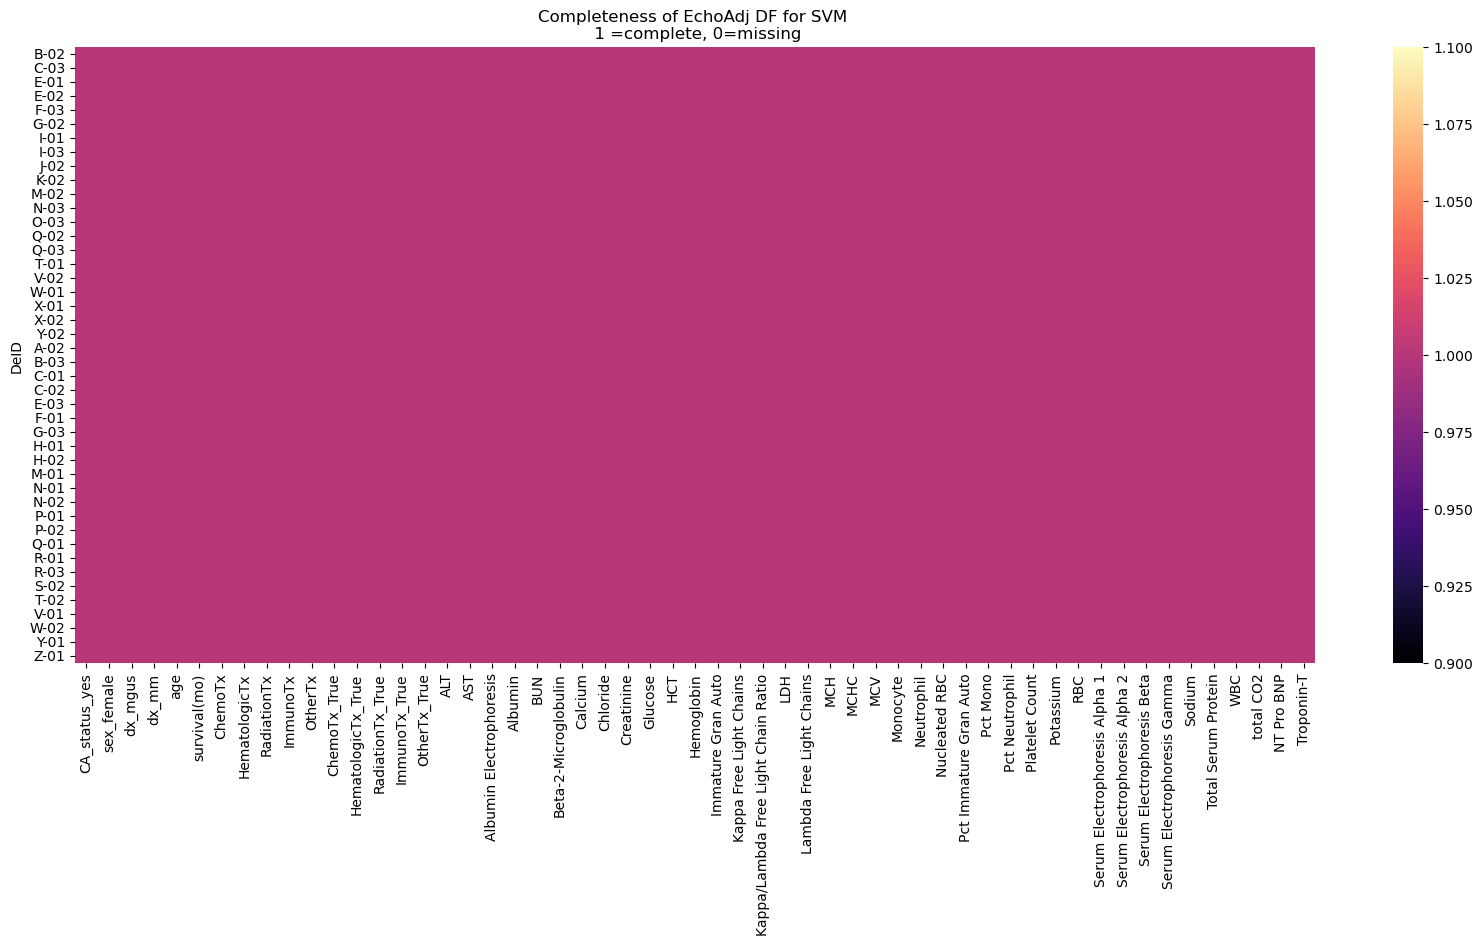

In [319]:
# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_ImagingAdj_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_ImagingAdj_df_knownpts.index, ax=ax)
plt.title("Completeness of EchoAdj DF for SVM \n 1 =complete, 0=missing")
# features_ImagingAdj_df_knownpts

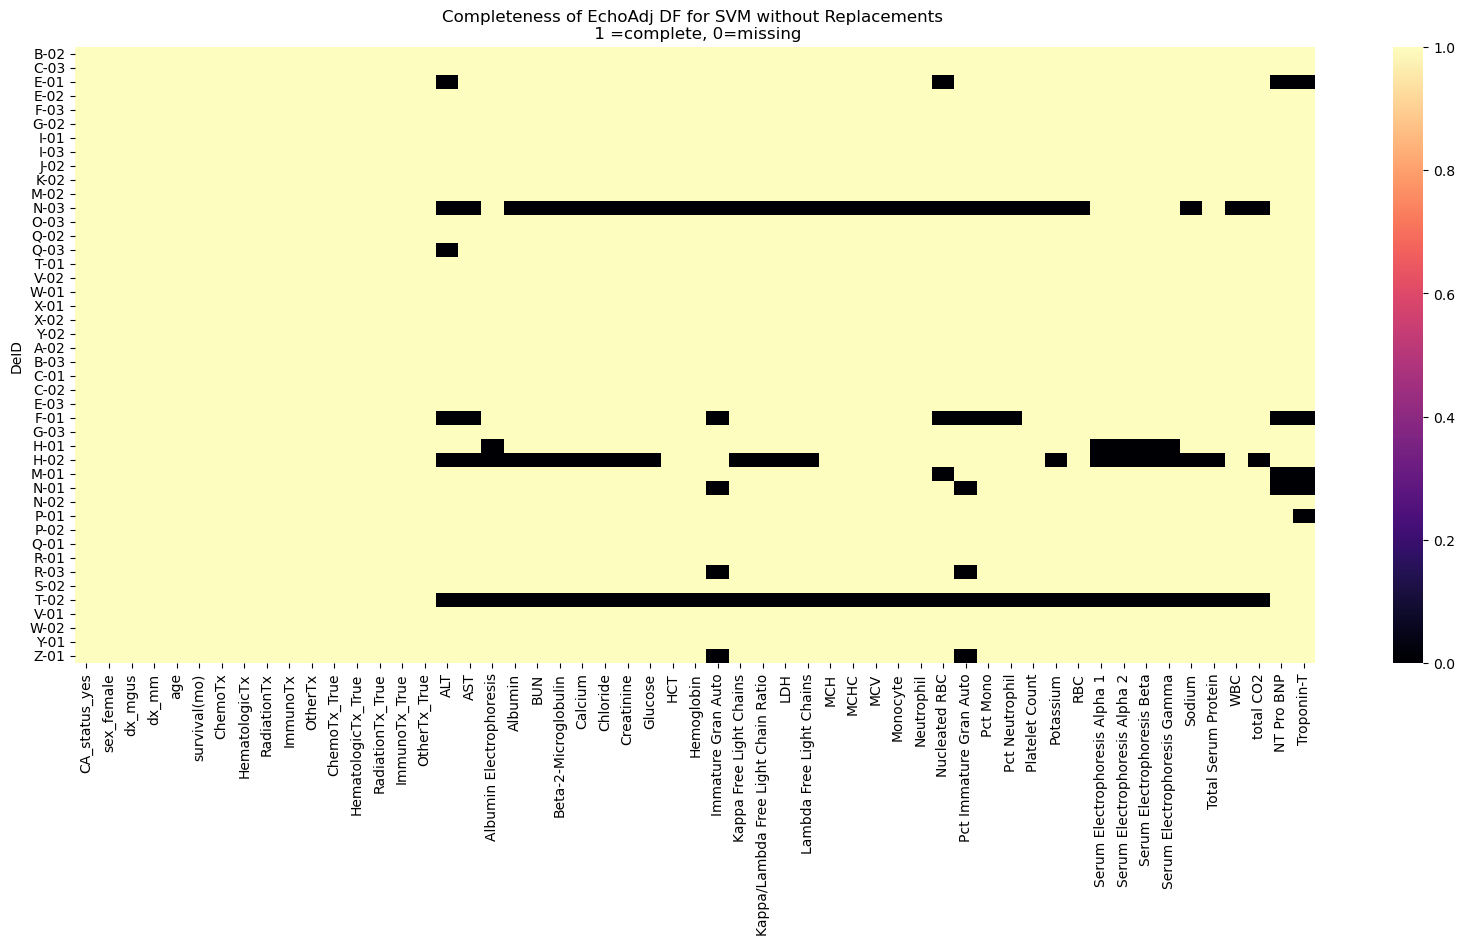

In [320]:
# heat map for features without the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_ImagingAdj_df_knownpts.replace(-1, np.nan).notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
            yticklabels=features_ImagingAdj_df_knownpts.index, ax=ax)
plt.title("Completeness of EchoAdj DF for SVM without Replacements \n 1 =complete, 0=missing")

figname = ptfn.outputFiguresPath(fileName_header= "DataCompleteness_EchoAdj_", fileName_mid= "allpts_", fileName_suff="250429", parent_dir=outputDir, folderName=folderNameOut)
fig.savefig(figname)

Text(0.5, 1.0, 'Completeness of DescOnly DF for SVM \n 1 =complete, 0=missing')

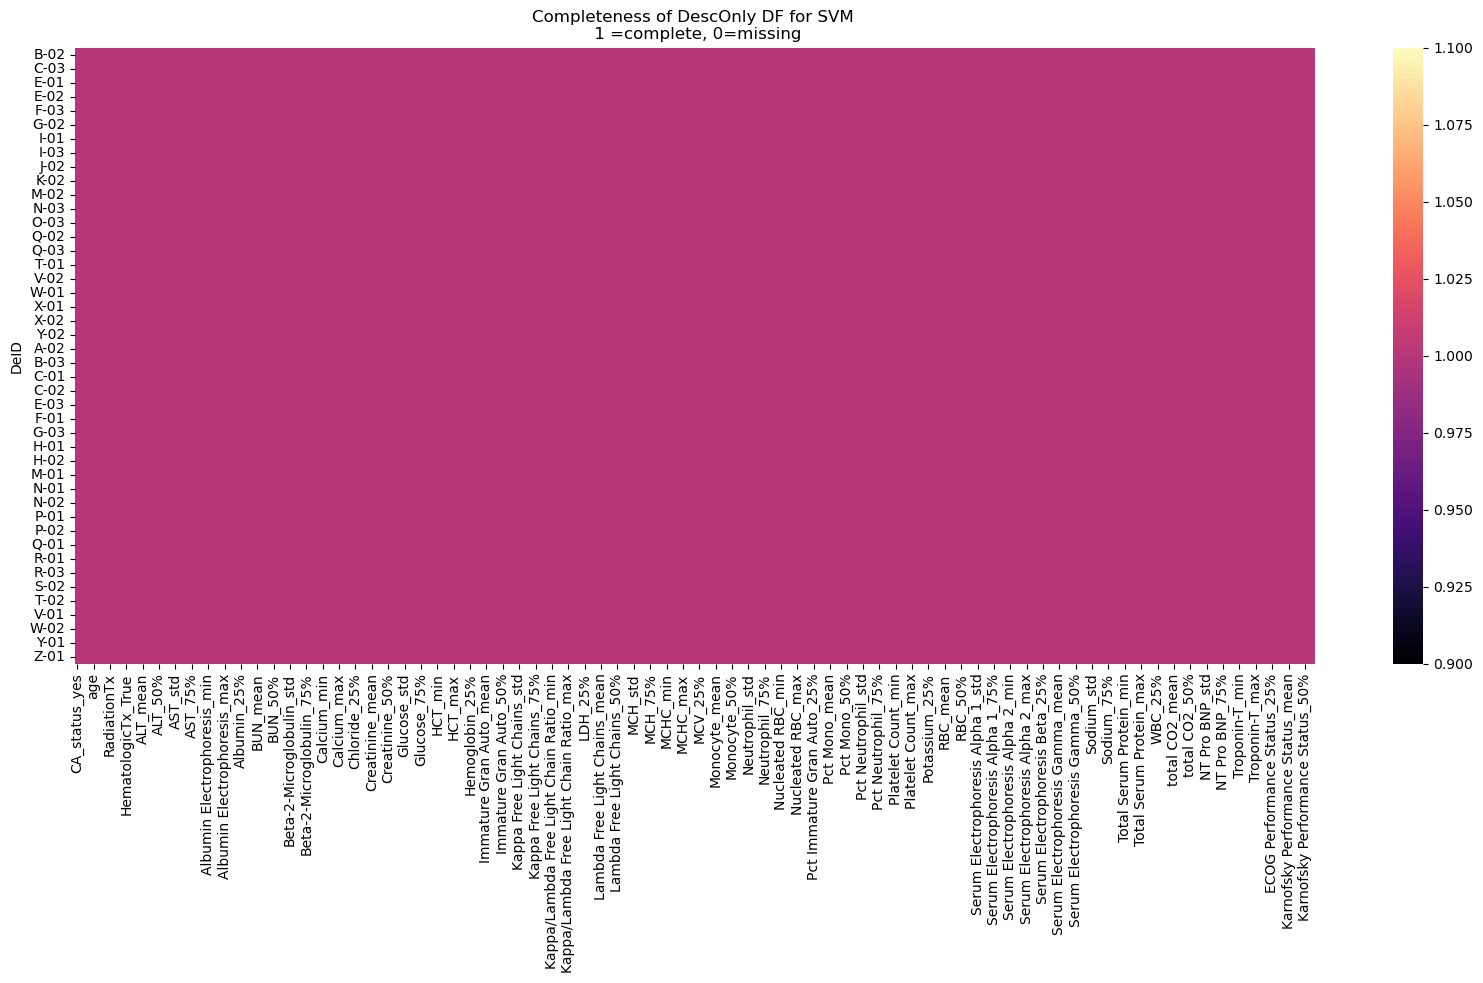

In [321]:
# features_DescOnly_df_knownpts

# heat map for features with the penalty score for missing data at time adjacent to imaging
fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(features_DescOnly_df_knownpts.notna(), cbar=True, cmap= 'magma', # linecolor= 'white', linewidths=0.5,
            yticklabels=features_DescOnly_df_knownpts.index, ax=ax)
plt.title("Completeness of DescOnly DF for SVM \n 1 =complete, 0=missing")


In [322]:
# # features_ParmasOnly_df_knownpts

# # heat map for features with the penalty score for missing data at time adjacent to imaging
# fig, ax = plt.subplots(figsize=(20, 8))

# sns.heatmap(features_ParmasOnly_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
#             yticklabels=features_ParmasOnly_df_knownpts.index, ax=ax)
# plt.title("Completeness of ParamsOnly DF for SVM \n 1 =complete, 0=missing")


In [323]:
# # features_DescFits_df_knownpts

# # heat map for features with the penalty score for missing data at time adjacent to imaging
# fig, ax = plt.subplots(figsize=(20, 8))

# sns.heatmap(features_DescFits_df_knownpts.notna(), cbar=True, cmap= 'magma', #linecolor= 'white', linewidths=0.5,
#             yticklabels=features_DescFits_df_knownpts.index, ax=ax)
# plt.title("Completeness of DescFits DF for SVM \n 1 =complete, 0=missing")


## event plots of the data
include the echo date

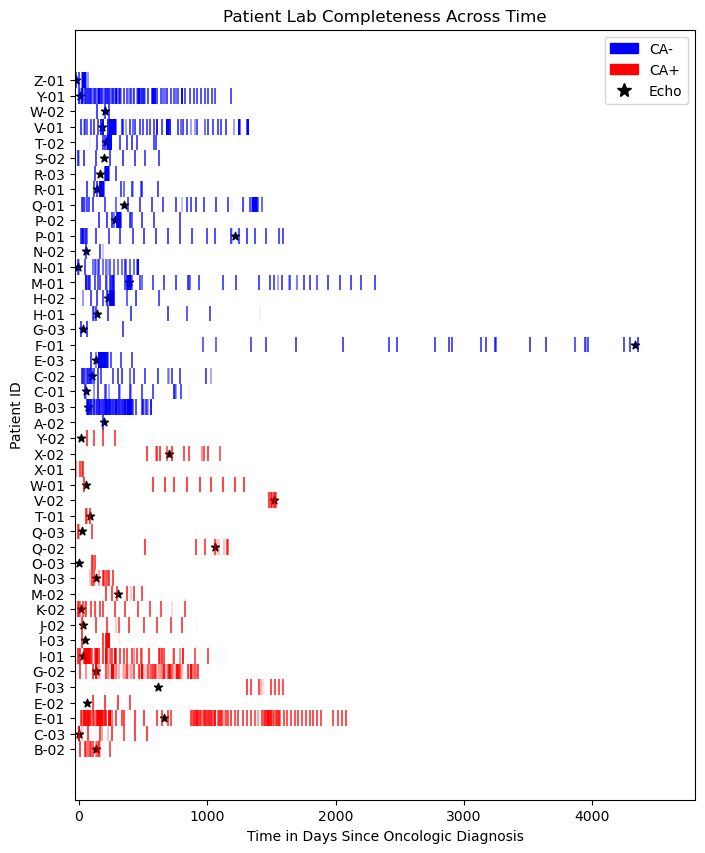

In [324]:
fig, ax = plt.subplots(figsize=(8,10))
#plot the data as an event plot
#plot the dict_time_complete_per_pt as an event plot where the listPositive are in red and the listNegative are in blue

echomarker = '*'
echomarker_color = "black"

i = 1
for pt in listPositive:
    ptLabData = ptDict[pt].labsData
    # ax.barh(y = i, width = ptDict[pt].survival*30.44, color = 'lightcoral', alpha = 1, label = 'CA+')
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'red', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

for pt in listNegative:
    ptLabData = ptDict[pt].labsData
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'blue', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

ax.set_xlim(-30,4800)
ax.set_yticks(np.arange(1, len(listKnown)+1, 1), listKnown, rotation = 'horizontal')

red_patch = mpatches.Patch(color='blue', label = 'CA-')
blue_patch = mpatches.Patch(color='red', label = 'CA+')
echomarker_line = plt.Line2D([0], [0], linestyle='none', marker=echomarker, color=echomarker_color, markersize=10, label=f'Echo')


ax.legend(handles=[red_patch, blue_patch, echomarker_line])

ax.set_title('Patient Lab Completeness Across Time')
ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
ax.set_ylabel('Patient ID')

figname = ptfn.outputFiguresPath(fileName_header= "EventPlot_", fileName_mid= "allpts_", fileName_suff="250429", parent_dir=outputDir, folderName=folderNameOut)
fig.savefig(figname)

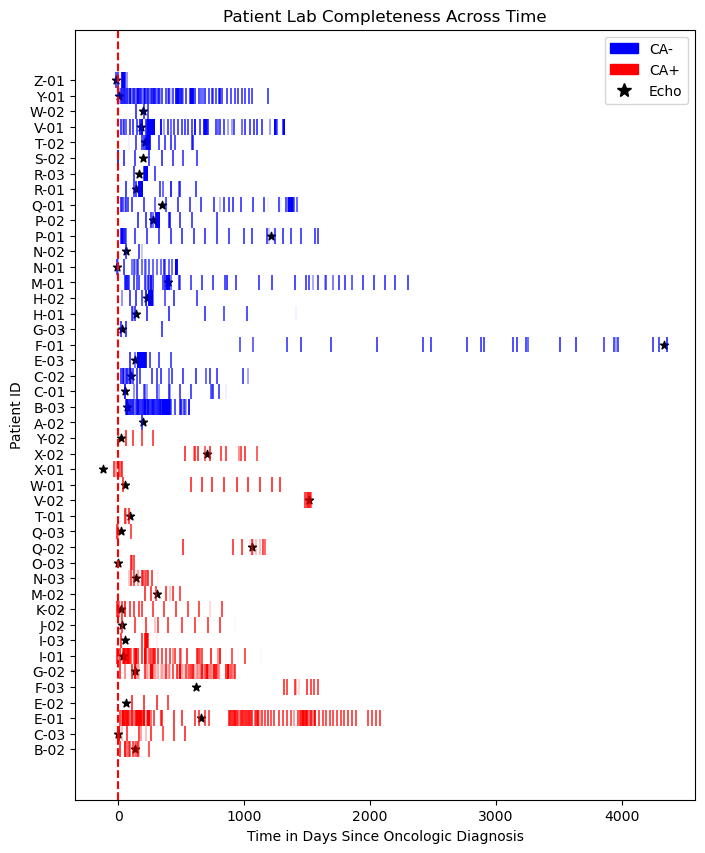

In [325]:
fig, ax = plt.subplots(figsize=(8,10))
#plot the data as an event plot
#plot the dict_time_complete_per_pt as an event plot where the listPositive are in red and the listNegative are in blue

echomarker = '*'
echomarker_color = "black"

i = 1
for pt in listPositive:
    ptLabData = ptDict[pt].labsData
    # ax.barh(y = i, width = ptDict[pt].survival*30.44, color = 'lightcoral', alpha = 1, label = 'CA+')
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'red', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

for pt in listNegative:
    ptLabData = ptDict[pt].labsData
    for lab in filteredLabs:
        ax.eventplot(data=ptLabData[lab], positions = ptLabData[ptLabData[lab].notna()]['RelTime(Days)'].tolist(),
                      lineoffsets=i, orientation='horizontal', color = 'blue', alpha = (1/len(filteredLabs)))

    #plot the echo date
    ax.scatter(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'] , y = i, marker = echomarker, color = echomarker_color, label = 'echo')
    i += 1

# ax.set_xlim(-30,4800)
ax.set_yticks(np.arange(1, len(listKnown)+1, 1), listKnown, rotation = 'horizontal')

red_patch = mpatches.Patch(color='blue', label = 'CA-')
blue_patch = mpatches.Patch(color='red', label = 'CA+')
echomarker_line = plt.Line2D([0], [0], linestyle='none', marker=echomarker, color=echomarker_color, markersize=10, label=f'Echo')


ax.legend(handles=[red_patch, blue_patch, echomarker_line])
ax.axvline(x = 0 , color='red', linestyle='--', label='onc dx')

ax.set_title('Patient Lab Completeness Across Time')
ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
ax.set_ylabel('Patient ID')

figname = ptfn.outputFiguresPath(fileName_header= "EventPlot_", fileName_mid= "allpts_long_", fileName_suff="250501", parent_dir=outputDir, folderName=folderNameOut)
fig.savefig(figname)

## plot of selected patient labs and fit of data

In [326]:
# ptsToPlot = ['H-02', 'V-01', 'B-02', 'E-01']
# lab = "Chloride"
# for pt in ptsToPlot: 
#     fig, ax = plt.subplots(figsize=(8,5))
#     ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
#     x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["none"])
#     x_values_flat = x_values.squeeze()
#     y_values_shift_flat = y_values_shift.squeeze()
#     #fit to the model
#     coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#     ax.scatter(x = x_values, y = y_values_shift + baseline, marker = 'o', color = 'blue', s = 5, alpha= 0.5, label = 'data')
#     #plot the line where y = mx + b and m = coef, b = intercept
#     ax.plot(x_values, y_prediction + intercept, color = 'gold', label = 'linear fit')

#     #add textbox below legend with coef, intercept, mse, r2
#     textstr = '\n'.join((
#         'linear fit',
#         r'$\mathrm{coef}=%.2f$' % (coef, ),
#         r'$\mathrm{intercept}=%.2f$' % (intercept, ),
#         r'$\mathrm{mse}=%.2f$' % (mse, ),
#         r'$\mathrm{r^2}=%.2f$' % (r2, )))
#     #add these patches to the figure 
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     # place a text box in upper left in axes coords
#     ax.text(0.01, -0.15, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=props)

#     #repeat for exponential fit on the same plot
#     x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"])
#     x_values_flat = x_values.squeeze()
#     y_values_shift_flat = y_values_shift.squeeze()
#     #fit to the model
#     coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#     #plot the line where y = mx + b and m = coef, b = intercept
#     ax.plot(x_values, np.exp(y_prediction + intercept)-1, color = 'orchid', label = 'exp fit')

#     #add textbox below legend with coef, intercept, mse, r2
#     textstr = '\n'.join((
#         'exp fit',
#         r'$\mathrm{coef}=%.2f$' % (coef, ),
#         r'$\mathrm{intercept}=%.2f$' % (intercept, ),
#         r'$\mathrm{mse}=%.2f$' % (mse, ),
#         r'$\mathrm{r^2}=%.2f$' % (r2, )))
#     #add these patches to the figure 
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax.text(0.25, -0.15, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=props)


#     # add vertical line for echo date imagingAndLabDates_df.loc[pt, 'ImagingDate']
#     ax.axvline(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'], color = 'red', linestyle = '--', label = 'echo date')

#     #legend
#     ax.legend( )
#     ax.set_title(f'Patient {pt} {lab}')
#     ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
#     ax.set_ylabel('Lab Value')

In [327]:
# ptsToPlot = ['H-02', 'V-01', 'B-02', 'E-01']
# lab = "NT Pro BNP"
# for pt in ptsToPlot: 
#     fig, ax = plt.subplots(figsize=(8,5))
#     ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
#     x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["none"])
#     x_values_flat = x_values.squeeze()
#     y_values_shift_flat = y_values_shift.squeeze()
#     #fit to the model
#     coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#     ax.scatter(x = x_values, y = y_values_shift + baseline, marker = 'o', color = 'blue', s = 5, alpha= 0.5, label = 'data')
#     #plot the line where y = mx + b and m = coef, b = intercept
#     ax.plot(x_values, y_prediction + intercept, color = 'gold', label = 'linear fit')

#     #add textbox below legend with coef, intercept, mse, r2
#     textstr = '\n'.join((
#         'linear fit',
#         r'$\mathrm{coef}=%.2f$' % (coef, ),
#         r'$\mathrm{intercept}=%.2f$' % (intercept, ),
#         r'$\mathrm{mse}=%.2f$' % (mse, ),
#         r'$\mathrm{r^2}=%.2f$' % (r2, )))
#     #add these patches to the figure 
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     # place a text box in upper left in axes coords
#     ax.text(0.01, -0.15, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=props)

#     #repeat for exponential fit on the same plot
#     x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"])
#     x_values_flat = x_values.squeeze()
#     y_values_shift_flat = y_values_shift.squeeze()
#     #fit to the model
#     coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#     #plot the line where y = mx + b and m = coef, b = intercept
#     ax.plot(x_values, np.exp(y_prediction + intercept)-1, color = 'orchid', label = 'exp fit')

#     #add textbox below legend with coef, intercept, mse, r2
#     textstr = '\n'.join((
#         'exp fit',
#         r'$\mathrm{coef}=%.2f$' % (coef, ),
#         r'$\mathrm{intercept}=%.2f$' % (intercept, ),
#         r'$\mathrm{mse}=%.2f$' % (mse, ),
#         r'$\mathrm{r^2}=%.2f$' % (r2, )))
#     #add these patches to the figure 
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax.text(0.25, -0.15, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=props)


#     # add vertical line for echo date imagingAndLabDates_df.loc[pt, 'ImagingDate']
#     ax.axvline(x = imagingAndLabDates_df.loc[pt, 'ImagingDate'], color = 'red', linestyle = '--', label = 'echo date')

#     #legend
#     ax.legend( )
#     ax.set_title(f'Patient {pt} {lab}')
#     ax.set_xlabel('Time in Days Since Oncologic Diagnosis')
#     ax.set_ylabel('Lab Value')

## grid plot 43 patients for troponin

In [328]:
len(listKnown)

44

In [329]:
#     # Define the lab to plot

# # labsOFInterest = [
# #     "Troponin-T", "Chloride", "Total Serum Protein", "Serum Electrophoresis Alpha 2",
# #     "NT Pro BNP", "Sodium", "Glucose", "Platelet Count", "LDH"
# # ]

# labsOFInterest = filteredLabs #to plot all of the filtered labs

# # Set up the grid of subplots
# num_patients = len(listKnown)
# cols = 9  # Number of columns in the grid
# rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed
# for lab in labsOFInterest:
#         fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
#         axes = axes.flatten()  # Flatten the axes array for easy indexing

#         # Loop through each patient and plot their data
#         for i, pt in enumerate(listKnown):
#             ax = axes[i]
#             ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
            
#             # Prepare data for linear fit
#             x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform=["none"])
#             x_values_flat = x_values.squeeze()
#             y_values_shift_flat = y_values_shift.squeeze()
            
#             #scatter plot of the original data
#             ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')

#             # Perform linear fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction + intercept, color='blue', label='linear fit')
            
#             # Prepare data for exponential fit
#             x_values, y_values_shift, baseline, datalength = prepDataForFit(ptLabsData, 'RelTime(Days)', lab, transform=["ln"])
#             x_values_flat = x_values.squeeze()
#             y_values_shift_flat = y_values_shift.squeeze()
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit(x_values_flat, y_values_shift_flat, baseline, datalength)
#             ax.plot(x_values, np.exp(y_prediction + intercept) - 1, color='orchid', label='exp fit')
            
#             # Add vertical line for echo date
#             ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
            
#             # Set title and labels
#             ax.set_title(f'Patient {pt}')
#             ax.set_xlabel('Time (Days)')
#             ax.set_ylabel(lab)

#         fig.suptitle(lab, y = 1)
        
#         # Remove unused subplots
#         for j in range(i + 1, len(axes)):
#             fig.delaxes(axes[j])

#         # Adjust layout
#         fig.tight_layout()
        
#         plt.show()
#         figname = ptfn.outputFiguresPath(fileName_header= "MultiPlot_DataFits_", fileName_mid= lab, fileName_suff="", parent_dir=outputDir, folderName=folderNameOut)
#         fig.savefig(figname)

## testing with sk fits

In [330]:
# labsOFInterest = filteredLabs #to plot all of the filtered labs

# # Set up the grid of subplots
# num_patients = len(listKnown)
# cols = 9  # Number of columns in the grid
# rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed
# for lab in labsOFInterest:
#         fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
#         axes = axes.flatten()  # Flatten the axes array for easy indexing

#         # Loop through each patient and plot their data
#         for i, pt in enumerate(listKnown):
#             ax = axes[i]
#             ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
            
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = False)

#             #scatter plot of the original data
#             ax.scatter(x_values, y_values_shift, marker='o', color='blue', s=5, alpha=0.5, label='data')

#             # Perform linear fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction, color='blue', label='linear fit')
            
#             # Prepare data for exponential fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=False)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
#             ax.plot(x_values, np.exp(y_prediction) - 1, color='violet', label='exp fit')
            
#             # Add vertical line for echo date
#             ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
            
#             # Set title and labels
#             ax.set_title(f'Patient {pt}')
#             ax.set_xlabel('Time (Days)')
#             ax.set_ylabel(lab)

#         fig.suptitle(lab, y = 1)
        
#         # Remove unused subplots
#         for j in range(i + 1, len(axes)):
#             fig.delaxes(axes[j])

#         # Adjust layout
#         fig.tight_layout()
        
#         plt.show()
#         figname = ptfn.outputFiguresPath(fileName_header= "MultiPlot_DataFits_sk_", fileName_mid= lab, fileName_suff="", parent_dir=outputDir, folderName=folderNameOut)
#         fig.savefig(figname)

## both sk and forced on the same plot

In [331]:
# labsOFInterest = filteredLabs #to plot all of the filtered labs

# # Set up the grid of subplots
# num_patients = len(listKnown)
# cols = 9  # Number of columns in the grid
# rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed
# for lab in labsOFInterest:
#         fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
#         axes = axes.flatten()  # Flatten the axes array for easy indexing

#         # Loop through each patient and plot their data
#         for i, pt in enumerate(listKnown):
#             ax = axes[i]
#             ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
            
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = False)

#             #scatter plot of the original data
#             ax.scatter(x_values, y_values_shift, marker='o', color='blue', s=5, alpha=0.5, label='data')

#             # Perform linear fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction, color='blue', label='linear fit sk')
            
#             # Prepare data for exponential fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=False)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
#             ax.plot(x_values, np.exp(y_prediction) - 1, color='violet', label='exp fit sk')
            
#             #forcing baseline linear fit
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = True)

#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= True)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction + intercept, color='firebrick', label='linear fit forced')

#             #forcing baseline exponential fit
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=True)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = True)
#             ax.plot(x_values, np.exp(y_prediction + intercept) - 1, color='orange', label='exp fit forced')


#             # Add vertical line for echo date
#             ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
            
#             # Set title and labels
#             ax.set_title(f'Patient {pt}')
#             ax.set_xlabel('Time (Days)')
#             ax.set_ylabel(lab)

#         fig.suptitle(lab, y = 1)
        
#         # Remove unused subplots
#         for j in range(i + 1, len(axes)):
#             fig.delaxes(axes[j])

#         # Adjust layout
#         fig.tight_layout()
        
#         plt.show()
#         # plt.legend()
#         figname = ptfn.outputFiguresPath(fileName_header= "MultiPlot_DataFits_all_", fileName_mid= lab, fileName_suff="", parent_dir=outputDir, folderName=folderNameOut)
#         fig.savefig(figname)

In [332]:
# labsOFInterest = filteredLabs #to plot all of the filtered labs
# # labsOFInterest = ['ALT', 'Chloride']

# # Set up the grid of subplots
# num_patients = len(listKnown)
# cols = 9  # Number of columns in the grid
# rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed
# for lab in labsOFInterest:
#         fig, axes = plt.subplots(rows, cols, figsize=(35, rows * 4))
#         axes = axes.flatten()  # Flatten the axes array for easy indexing

#         # Loop through each patient and plot their data
#         for i, pt in enumerate(listKnown):
#             ax = axes[i]
#             ptLabsData = ptDict[pt].labsData[['RelTime(Days)', lab]]
            
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = False)

#             #scatter plot of the original data
#             ax.scatter(x_values, y_values_shift, marker='o', color='blue', s=5, alpha=0.5, label='data')

#             # Perform linear fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction, color='indigo', label='linear fit sk')
            
#             # Prepare data for exponential fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=False)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
#             ax.plot(x_values, np.exp(y_prediction) - 1, color='darkviolet', label='exp fit sk')
            
#             #forcing baseline linear fit
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = True)

#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= True)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction + intercept, color='darkorange', label='linear fit forced')

#             #forcing baseline exponential fit
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=True)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = True)
#             ax.plot(x_values, np.exp(y_prediction + intercept) - 1, color='gold', label='exp fit forced')

#             ######repeat process but using only the time since diagnosis########
#             # Prepare data for linear fit without forcing baseline
#             ptLabsData = ptLabsData.loc[ptLabsData['RelTime(Days)']>= 0].reset_index()
#             ptLabsData = ptLabsData[['RelTime(Days)', lab]]
#             # x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = False)

#             # # Perform linear fit
#             # coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= False)
#             # # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             # ax.plot(x_values, y_prediction, color='dimgray', label='linear fit sk since dx')
            
#             # # Prepare data for exponential fit without forcing baseline
#             # x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=False)
            
#             # # Perform exponential fit
#             # coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = False)
#             # ax.plot(x_values, np.exp(y_prediction) - 1, color='silver', label='exp fit sk')
            
#             #forcing baseline linear fit
#             # Prepare data for linear fit without forcing baseline
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["none"], shift = True)

#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced= True)
#             # ax.scatter(x_values, y_values_shift + baseline, marker='o', color='blue', s=5, alpha=0.5, label='data')
#             ax.plot(x_values, y_prediction + intercept, color='darkolivegreen', label='linear fit forced')

#             #forcing baseline exponential fit
#             x_values, y_values_shift, datalength, baseline = prepDataForFit_v2(ptLabsData, 'RelTime(Days)', lab, transform = ["ln"], shift=True)
            
#             # Perform exponential fit
#             coef, intercept, mse, r2, y_prediction = linear_model_fit_v2(x = x_values, y=  y_values_shift, datalength=datalength, baseline = baseline, forced = True)
#             ax.plot(x_values, np.exp(y_prediction + intercept) - 1, color='yellowgreen', label='exp fit forced')



#             # Add vertical line for echo date
#             ax.axvline(x=imagingAndLabDates_df.loc[pt, 'ImagingDate'], color='red', linestyle='--', label='echo date')
            
#             # Set title and labels
#             ax.set_title(f'Patient {pt}')
#             ax.set_xlabel('Time (Days)')
#             ax.set_ylabel(lab)

#         fig.suptitle(lab, y = 1)
        
#         # Remove unused subplots
#         for j in range(i + 1, len(axes)):
#             fig.delaxes(axes[j])

#         # Adjust layout
#         fig.tight_layout()
        
#         plt.show()
#         # plt.legend()
#         figname = ptfn.outputFiguresPath(fileName_header= "MultiPlot_DataFits_all_", fileName_mid= lab, fileName_suff="", parent_dir=outputDir, folderName=folderNameOut)
#         fig.savefig(figname)